In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import wasserstein_distance
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from tqdm import tqdm
import random

## Data

In [2]:
transactions = pd.read_csv('https://raw.githubusercontent.com/BigTuna08/Banksformer_ecml_2022/main/czech/banksformer/data/tr_by_acct_w_age.csv',
                            parse_dates=['date'])
transactions.head()

,Unnamed: 0,account_id,date,type,operation,amount,balance,k_symbol,client_id,age,datetime
0,149432,1,1995-03-24,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,1,29,1995-03-24
1,157404,1,1995-04-13,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,1,29,1995-04-13
2,158832,1,1995-04-23,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,1,29,1995-04-23
3,162681,1,1995-04-30,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,1,29,1995-04-30
4,167083,1,1995-05-13,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,1,29,1995-05-13


In [3]:
useful_cols = ['account_id', 'date', 'type', 'operation', 'amount', 'k_symbol'] # removed trans_id and balance
cts_cols = ['amount']
cat_cols = ['type', 'operation', 'k_symbol']

In [4]:
real = transactions[useful_cols]
real = real.fillna('')
real.head()

,account_id,date,type,operation,amount,k_symbol
0,1,1995-03-24,CREDIT,CREDIT IN CASH,1000.0,
1,1,1995-04-13,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,
2,1,1995-04-23,CREDIT,CREDIT IN CASH,12600.0,
3,1,1995-04-30,CREDIT,,19.2,INTEREST CREDITED
4,1,1995-05-13,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,


In [5]:
def csv_to_df(csv_file, useful_cols):
  res = pd.read_csv(csv_file, parse_dates=['date'])
  res = res[useful_cols]
  res = res.fillna('')
  return res

In [6]:
ctgan_data = 'SyntheticCTGAN_500Epochs_ParsedDates.csv'
doppel_data = 'SyntheticDGAN.csv'
banksformer_data = 'SyntheticBF.csv'
tvae_data = 'SyntheticTVAE.csv'

In [7]:
bf = csv_to_df(banksformer_data, useful_cols)
dg = csv_to_df(doppel_data, useful_cols)

In [44]:
dg.head()

,account_id,date,type,operation,amount,k_symbol
0,1,1385-10-15 00:00:00,CREDIT,0,14268.33,0
1,1,1725-02-22 00:00:00,CREDIT,0,14268.85,0
2,1,1798-10-10 00:00:00,CREDIT,0,14268.88,0
3,1,1875-11-20 00:00:00,CREDIT,0,14268.49,
4,1,1911-03-04 00:00:00,CREDIT,CREDIT IN CASH,14269.71,


In [8]:
ct = pd.read_csv(ctgan_data)
tvae = pd.read_csv(tvae_data)

In [12]:
tvae.head()

,Unnamed: 0.1,Unnamed: 0,account_id,type,operation,amount,k_symbol,month,day,year,date
0,0,0.0,3988.0,CREDIT,CREDIT IN CASH,6852.1,NaN,12.0,10.0,1998.0,1998-12-10
1,1,1.0,756.0,DEBIT,CASH WITHDRAWAL,23479.7,NaN,8.0,20.0,1998.0,1998-08-20
2,2,2.0,3843.0,DEBIT,REMITTANCE TO ANOTHER BANK,1598.4,HOUSEHOLD,12.0,5.0,1998.0,1998-12-05
3,3,3.0,5136.0,CREDIT,CREDIT IN CASH,2000.5,NaN,8.0,18.0,1997.0,1997-08-18
4,4,4.0,4127.0,DEBIT,CREDIT CARD WITHDRAWAL,324.3,NaN,12.0,20.0,1998.0,1998-12-20


Code for if directly from CTGAN ouput to process days that don't exist.

In [ ]:
## ONLY RUN THIS ON DATA WITHOUT DATES

# Removes rows where days are out of the month range
import calendar

def process_days(df):
  for index, row in df.iterrows():
    days_in_month = calendar.monthrange(row['year'], row['month'])[1]
    if row['day'] > days_in_month:
      df = df.drop(index)

  # Adds date col
  df['date'] = pd.to_datetime(df['day'].astype(str) + '-' + df['month'].astype(str) + '-' + df['year'].astype(str), format='%d-%m-%Y')
  df.reset_index(drop=True, inplace=True)

In [ ]:
process_days(tvae)
process_days(ct)

In [9]:
ct = ct[useful_cols]
ct = ct.fillna('')
ct.head()

,account_id,date,type,operation,amount,k_symbol
0,1340,1998-05-05,DEBIT,REMITTANCE TO ANOTHER BANK,6185.7,INSURANCE PAYMENT
1,6133,1997-12-21,DEBIT,CASH WITHDRAWAL,4873.9,
2,2700,1997-09-18,CREDIT,CREDIT IN CASH,46066.5,
3,1036,1994-04-14,CREDIT,COLLECTION FROM ANOTHER BANK,9288.3,
4,1436,1998-01-05,CREDIT,COLLECTION FROM ANOTHER BANK,5109.8,OLD AGE PENSION


In [10]:
tvae = tvae[useful_cols]
tvae = tvae.fillna('')
tvae.head()

,account_id,date,type,operation,amount,k_symbol
0,3988,1998-12-10,CREDIT,CREDIT IN CASH,6852.1,
1,756,1998-08-20,DEBIT,CASH WITHDRAWAL,23479.7,
2,3843,1998-12-05,DEBIT,REMITTANCE TO ANOTHER BANK,1598.4,HOUSEHOLD
3,5136,1997-08-18,CREDIT,CREDIT IN CASH,2000.5,
4,4127,1998-12-20,DEBIT,CREDIT CARD WITHDRAWAL,324.3,


In [15]:
print(f"Number of unique account_ids in real data: { real['account_id'].nunique()}")
print(f"Number of unique account_ids in CTGAN data: { ct['account_id'].nunique()}")
print(f"Number of unique account_ids in DoppelGAN data: { dg['account_id'].nunique()}")
print(f"Number of unique account_ids in Banksformer data: { bf['account_id'].nunique()}")
print(f"Number of unique account_ids in TVAE data: { tvae['account_id'].nunique()}")

Number of unique account_ids in real data: 4500
Number of unique account_ids in CTGAN data: 11382
Number of unique account_ids in DoppelGAN data: 4500
Number of unique account_ids in Banksformer data: 4500
Number of unique account_ids in TVAE data: 11378


In [15]:
# only run this if running initial data processing
fake1 = bf
fake2 = dg
fake3 = ct

## Membership Inference


### Initial data processing

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting real dataframe
real_train, real_test = train_test_split(real, test_size=0.2, stratify=real['account_id'])
fake1_train, fake1_test = train_test_split(fake1, test_size=0.2, stratify=fake1['account_id'])
fake2_train, fake2_test = train_test_split(fake2, test_size=0.2, stratify=fake2['account_id'])

In [ ]:
# add labels
real_train['label'] = 0
real_test['label'] = 0
fake1_train['label'] = 1
fake1_test['label'] = 1
fake2_train['label'] = 1
fake2_test['label'] = 1

In [ ]:
# final train and test sets
train1 = pd.concat([real_train, fake1_train], axis=0)
test1 = pd.concat([real_test, fake1_test], axis=0)

train2 = pd.concat([real_train, fake2_train], axis=0)
test2 = pd.concat([real_test, fake2_test], axis=0)

In [ ]:
train1 = train1[pd.to_datetime(train1['date'], dayfirst=True, errors='coerce').notnull()]
test1 = test1[pd.to_datetime(test1['date'], dayfirst=True, errors='coerce').notnull()]
train2 = train2[pd.to_datetime(train2['date'], dayfirst=True, errors='coerce').notnull()]
test2 = test2[pd.to_datetime(test2['date'], dayfirst=True, errors='coerce').notnull()]

In [ ]:
# Convert categorical variables into numerical labels using one-hot encoding

train1 = pd.get_dummies(train1, columns=['type', 'operation', 'k_symbol'])
test1 = pd.get_dummies(test1, columns=['type', 'operation', 'k_symbol'])

# Convert date column to be int64
# train1['date'] = pd.to_datetime(train1['date'], dayfirst=True).astype('int64')
# test1['date'] = pd.to_datetime(test1['date'], dayfirst=True).astype('int64')

# same for 2
train2 = pd.get_dummies(train2, columns=['type', 'operation', 'k_symbol'])
test2 = pd.get_dummies(test2, columns=['type', 'operation', 'k_symbol'])

# train2['date'] = pd.to_datetime(train2['date'], dayfirst=True).astype('int64')
# test2['date'] = pd.to_datetime(test2['date'], dayfirst=True).astype('int64')

In [ ]:
# drop account_id columns
train1.drop(columns=['account_id'], inplace=True)
test1.drop(columns=['account_id'], inplace=True)
train2.drop(columns=['account_id'], inplace=True)
test2.drop(columns=['account_id'], inplace=True)

In [ ]:
train1.tail()

,date,amount,label,type_CREDIT,type_DEBIT,type_WITHDRAWAL,operation_0,operation_CASH WITHDRAWAL,operation_COLLECTION FROM ANOTHER BANK,operation_CREDIT CARD WITHDRAWAL,...,k_symbol_HOUSHOLD,k_symbol_INSURANCE PAYMENT,k_symbol_INTEREST CREDITED,k_symbol_LOAN PAYMENT,k_symbol_OLD AGE PENSION,k_symbol_OLD-AGE PENSION,k_symbol_PAYMENT FOR STATEMENT,k_symbol_PAYMENT ON STATEMENT,k_symbol_SANCTION INTEREST,k_symbol_nan
402760,2086-11-01 00:00:00,9575.29,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
793835,2068-02-09 00:00:00,10075.40,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
225945,2127-02-11 00:00:00,14368.28,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
586999,1919-02-06 00:00:00,7751.93,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
710459,2161-02-24 00:00:00,27607.62,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Evaluation Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def rand_forest(train, test):
  # Extract features and target variable
  X_train = train.drop(columns=['label'])
  y_train = train['label']
  X_test = test.drop(columns=['label'])
  y_test = test['label']

  # Step 2: Train a classifier (Random Forest Classifier)
  clf = RandomForestClassifier(n_estimators=100, random_state=42)
  clf.fit(X_train, y_train)

  # Step 3: Evaluate the classifier
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy of the classifier:", accuracy)

  # confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  cmp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
  cmp.plot()
  plt.title("Confusion Matrix")

  return accuracy

In [ ]:
from sklearn.linear_model import LogisticRegression

def log_reg(train, test):
  # Extract features and target variable
  X_train = train.drop(columns=['label'])
  y_train = train['label']
  X_test = test.drop(columns=['label'])
  y_test = test['label']

  # Step 2: Train a classifier (Logistic Regression)
  clf = LogisticRegression(random_state=42, max_iter = 200)
  clf.fit(X_train, y_train)

  # Step 3: Evaluate the classifier
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy of the classifier:", accuracy)

  # confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  cmp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
  cmp.plot()
  plt.title("Confusion Matrix")

  return accuracy

In [ ]:
import xgboost

def xgboost_eval(train, test):
  # Extract features and target variable
  X_train = train.drop(columns=['label'])
  y_train = train['label']
  X_test = test.drop(columns=['label'])
  y_test = test['label']

  # Step 2: Train a classifier (XGBoost)
  clf = xgboost.XGBClassifier(random_state=42)
  clf.fit(X_train, y_train)

  # Step 3: Evaluate the classifier
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy of the classifier:", accuracy)

  # confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  cmp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
  cmp.plot()
  plt.title("Confusion Matrix")

  return accuracy

### Initial Results

In [ ]:
train1_intDate = train1.copy()
train1_intDate['date'] = pd.to_datetime(train1_intDate['date'], dayfirst=True).astype('int64')
test1_intDate = test1.copy()
test1_intDate['date'] = pd.to_datetime(test1_intDate['date'], dayfirst=True).astype('int64')

train2_intDate = train2.copy()
train2_intDate['date'] = pd.to_datetime(train2_intDate['date'], dayfirst=True).astype('int64')
test2_intDate = test2.copy()
test2_intDate['date'] = pd.to_datetime(test2_intDate['date'], dayfirst=True).astype('int64')

rand_forest(train1_intDate, test1_intDate)
rand_forest(train2_intDate, test2_intDate)


Accuracy of the classifier: 0.999691519030517
Accuracy of the classifier: 0.9506185042928151


In [ ]:
log_reg(train1_intDate, test1_intDate)
log_reg(train2_intDate, test2_intDate)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the classifier: 0.5298449068036356


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the classifier: 0.745820153637596


In [ ]:
xgboost_eval(train1_intDate, test1_intDate)
xgboost_eval(train2_intDate, test2_intDate)

Accuracy of the classifier: 0.9994958969523083
Accuracy of the classifier: 0.9437450576140985


#### Evaluate mutual information

In [ ]:
# Calculate PMI of different features compared to the label
from sklearn.feature_selection import mutual_info_classif

def mutual_info(X, y, data_name):
  # X is your input feature set
  # y is your output
  mutual_info = mutual_info_classif(X, y)
  mutual_info_with_indices = list(enumerate(mutual_info))

  # Sort the list of tuples based on mutual information values in descending order
  mutual_info_with_indices.sort(key=lambda x: x[1], reverse=True)

  # Extract the feature indices sorted by mutual information values
  sorted_feature_indices = [index for index, _ in mutual_info_with_indices]
  feature_names = X.columns[sorted_feature_indices]

  plt.figure(figsize=(10, 6))
  plt.bar(feature_names, mutual_info[sorted_feature_indices])
  plt.xticks(rotation=90)
  plt.xlabel('Features')
  plt.ylabel('Mutual Information')
  plt.title(data_name+'Mutual Information with Feature Names')
  plt.show()
  return mutual_info

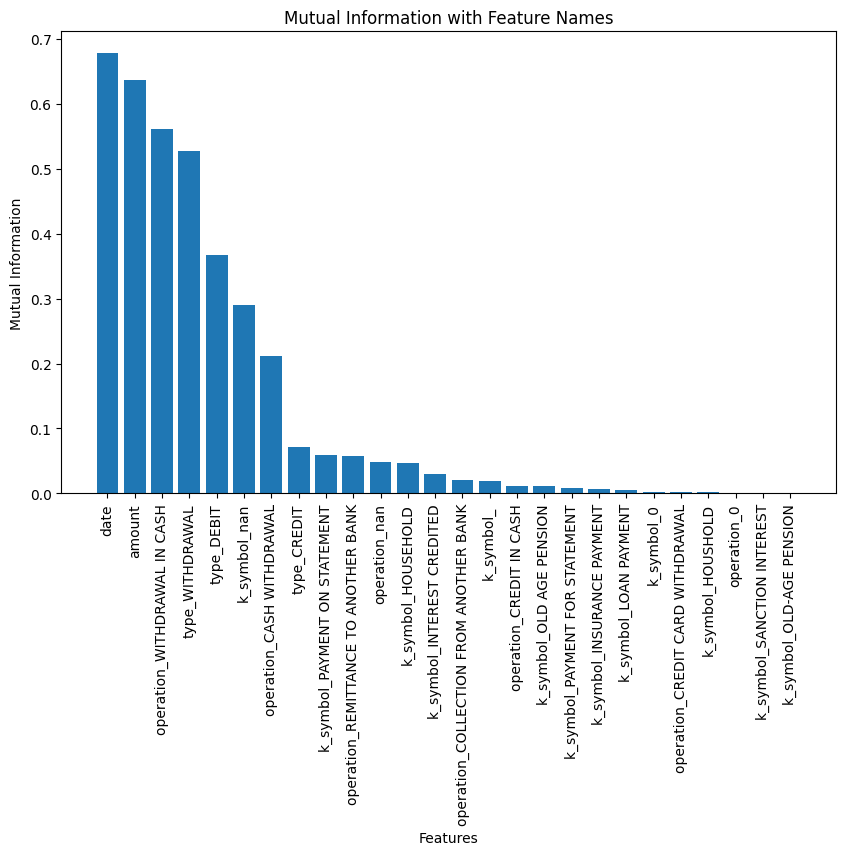

In [ ]:
mi = mutual_info(train1.drop(columns=['label']), train1['label'], 'DoppelGANger')

In [ ]:
# prompt: print range of dates from real data

print("range of dates from real data is " + str(real['date'].min()) + " to " + str(real['date'].max()))
print("range of dates from Doppel data is " + str(fake1['date'].min()) + " to " + str(fake1['date'].max()))

range of dates from real data is 1993-01-01 00:00:00 to 1998-12-31 00:00:00
range of dates from Doppel data is 0651-10-06 00:00:00 to 2228-02-14 00:00:00


In [ ]:
print("range of amounts from real data is " + str(real['amount'].min()) + " to " + str(real['amount'].max()))
print("range of amounts from Doppel data is " + str(fake1['amount'].min()) + " to " + str(fake1['amount'].max()))

range of amounts from real data is 0.0 to 87400.0
range of amounts from Doppel data is 3687.45 to 35496.73


In [ ]:
start_date = pd.to_datetime(real['date'], dayfirst=True).astype('int64').min()
end_date = pd.to_datetime(real['date'], dayfirst=True).astype('int64').max()

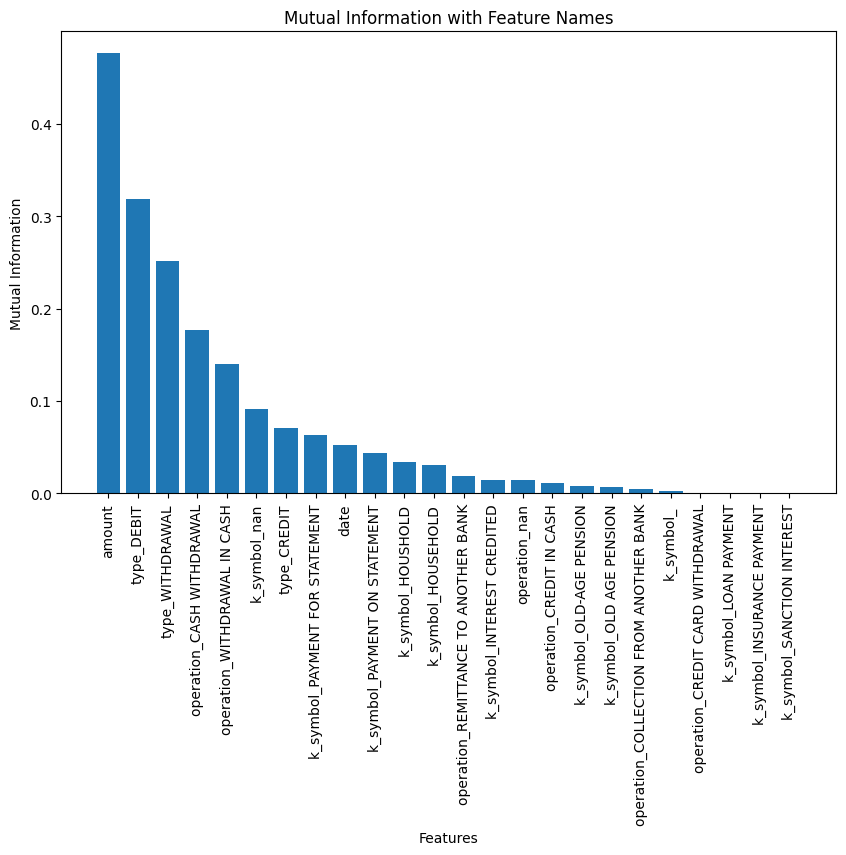

In [ ]:
mi2 = mutual_info(train2.drop(columns=['label']), train2['label'])

In [ ]:
# prompt: print range of amounts from different datasets

print("range of amounts from real data is " + str(real['amount'].min()) + " to " + str(real['amount'].max()))
print("range of amounts from BF data is " + str(fake2['amount'].min()) + " to " + str(fake2['amount'].max()))


range of amounts from real data is 0.0 to 87400.0
range of amounts from BF data is 0.0 to 24066.96


#### Rescaling combinations

In [ ]:
print(fake1['date'][0])
print(fake1['date'][0] > '1993-01-01')
print(fake1['date'][0] < '1999-12-31')
print(type(fake1['date'][0]))

1385-10-15 00:00:00
False
True
<class 'str'>


In [ ]:
# removed out of bounds
fake1_dropped_dates = fake1.drop(fake1[(fake1['date'] < '1993-01-01') | (fake1['date'] > '1999-12-31')].index)
fake1_dropped_dates.reset_index(drop=True, inplace=True)
fake1_dropped_dates.head()

,account_id,date,type,operation,amount,k_symbol
0,2,1993-10-24 00:00:00,WITHDRAWAL,REMITTANCE TO ANOTHER BANK,6487.09,nan
1,2,1995-10-15 00:00:00,WITHDRAWAL,CREDIT IN CASH,6487.57,nan
2,2,1999-01-27 00:00:00,CREDIT,COLLECTION FROM ANOTHER BANK,6488.48,INTEREST CREDITED
3,6,1993-03-08 00:00:00,CREDIT,WITHDRAWAL IN CASH,6745.87,INTEREST CREDITED
4,6,1996-03-03 00:00:00,CREDIT,CREDIT IN CASH,6746.69,nan


In [ ]:
fake1_dropped_dates['account_id'].nunique()

1704

In [ ]:
fake1_dropped_dates.shape

(5659, 6)

In [ ]:
fake1_dropped_dates['date'].max(), fake1_dropped_dates['date'].min()

('1999-12-30 00:00:00', '1993-01-02 00:00:00')

In [ ]:
# fake1 = fake1[pd.to_datetime(fake1['date'], dayfirst=True, errors='coerce').notnull()]
# fake1_new_again = fake1.copy()
# fake1_new_again['date'] = pd.to_datetime(fake1['date'], dayfirst=True).astype('int64')
# fake1_new_again.tail()

,account_id,date,type,operation,amount,k_symbol
950161,11382,6112195200000000000,WITHDRAWAL,WITHDRAWAL IN CASH,20376.89,nan
950162,11382,6113923200000000000,WITHDRAWAL,WITHDRAWAL IN CASH,20378.43,nan
950163,11382,6114700800000000000,WITHDRAWAL,WITHDRAWAL IN CASH,20377.56,nan
950164,11382,6119452800000000000,WITHDRAWAL,WITHDRAWAL IN CASH,20378.77,nan
950165,11382,6124896000000000000,WITHDRAWAL,WITHDRAWAL IN CASH,20377.89,nan


Re-scaling amounts down to similar amounts as real data

In [ ]:
fake1_normalized_amounts = fake1.copy()
min_amount = real['amount'].min()
max_amount = real['amount'].max()
fake1_normalized_amounts['amount'] = (fake1['amount'] - fake1['amount'].min()) * (max_amount - min_amount) / (fake1['amount'].max() - fake1['amount'].min()) + min_amount
fake1_normalized_amounts.head()


,account_id,date,type,operation,amount,k_symbol
0,1,1385-10-15 00:00:00,CREDIT,0,29072.299404,0
1,1,1725-02-22 00:00:00,CREDIT,0,29073.728170,0
2,1,1798-10-10 00:00:00,CREDIT,0,29073.810599,0
3,1,1875-11-20 00:00:00,CREDIT,0,29072.739025,nan
4,1,1911-03-04 00:00:00,CREDIT,CREDIT IN CASH,29076.091128,nan


In [ ]:
assert(fake1_normalized_amounts['amount'].min() == real['amount'].min())
assert(fake1_normalized_amounts['amount'].max() == real['amount'].max())

In [ ]:
fake1_normalized_amounts.shape

(950166, 6)

In [ ]:
real.head()

,account_id,date,type,operation,amount,k_symbol
0,1,1995-03-24,CREDIT,CREDIT IN CASH,1000.0,nan
1,1,1995-04-13,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,nan
2,1,1995-04-23,CREDIT,CREDIT IN CASH,12600.0,nan
3,1,1995-04-30,CREDIT,nan,19.2,INTEREST CREDITED
4,1,1995-05-13,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,nan


In [ ]:
real_test= real[pd.to_datetime(real['date'], dayfirst=True, errors='coerce').notnull()]
real_test.reset_index(drop=True, inplace=True)
real_test.head()

,account_id,date,type,operation,amount,k_symbol
0,1,1995-03-24,CREDIT,CREDIT IN CASH,1000.0,nan
1,1,1995-04-13,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,nan
2,1,1995-04-23,CREDIT,CREDIT IN CASH,12600.0,nan
3,1,1995-04-30,CREDIT,nan,19.2,INTEREST CREDITED
4,1,1995-05-13,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,nan


Defined new method taking dataframes, outputting train and test set

In [ ]:
from sklearn.model_selection import train_test_split

def membershipInferenceData(real_df, fake_df, test_size=0.2):

  real_train, real_test = train_test_split(real_df, test_size=test_size, stratify=real_df['account_id'])
  fake_train, fake_test = train_test_split(fake_df, test_size=test_size, stratify=fake_df['account_id'])

  real_train['label'] = 0
  real_test['label'] = 0
  fake_train['label'] = 1
  fake_test['label'] = 1

  train = pd.concat([real_train, fake_train], axis=0)
  test = pd.concat([real_test, fake_test], axis=0)

  train= train[pd.to_datetime(train['date'], dayfirst=True, errors='coerce').notnull()]
  test= test[pd.to_datetime(test['date'], dayfirst=True, errors='coerce').notnull()]
  train['date'] = pd.to_datetime(train['date'], dayfirst=True).astype('int64')
  test['date'] = pd.to_datetime(test['date'], dayfirst=True).astype('int64')

  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)

  train = pd.get_dummies(train, columns=['type', 'operation', 'k_symbol'])
  test = pd.get_dummies(test, columns=['type', 'operation', 'k_symbol'])

  train.drop(columns=['account_id'], inplace=True)
  test.drop(columns=['account_id'], inplace=True)

  return train, test

In [ ]:
train_normalized_amt, test_normalized_amt = membershipInferenceData(real, fake1_normalized_amounts)

In [ ]:
train_normalized_amt.head()

,date,amount,label,type_CREDIT,type_DEBIT,type_WITHDRAWAL,operation_0,operation_CASH WITHDRAWAL,operation_COLLECTION FROM ANOTHER BANK,operation_CREDIT CARD WITHDRAWAL,...,k_symbol_HOUSHOLD,k_symbol_INSURANCE PAYMENT,k_symbol_INTEREST CREDITED,k_symbol_LOAN PAYMENT,k_symbol_OLD AGE PENSION,k_symbol_OLD-AGE PENSION,k_symbol_PAYMENT FOR STATEMENT,k_symbol_PAYMENT ON STATEMENT,k_symbol_SANCTION INTEREST,k_symbol_nan
471124,1996-05-10 00:00:00,13641.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
676463,1998-05-17 00:00:00,1500.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
962031,1996-12-11 00:00:00,25654.5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
340398,1997-03-09 00:00:00,2899.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
588215,1993-12-23 00:00:00,2800.0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
res = log_reg(train_normalized_amt, test_normalized_amt)

Accuracy of the classifier: 0.5298369338957801


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
rand_forest(train_normalized_amt, test_normalized_amt)

Accuracy of the classifier: 0.9996112696685008


In [ ]:
xgboost_eval(train_normalized_amt, test_normalized_amt)

Accuracy of the classifier: 0.9993805300856724


Try smaller training data (attacker only knows a small real-fake difference)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the classifier: 0.5298369338957801
split: 0.2, accuracy: 0.5298369338957801


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the classifier: 0.5297519044729412
split: 0.1, accuracy: 0.5297519044729412


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the classifier: 0.5297279948647998
split: 0.05, accuracy: 0.5297279948647998


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the classifier: 0.5299685597698843
split: 0.03, accuracy: 0.5299685597698843


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of the classifier: 0.5295768999398436
split: 0.01, accuracy: 0.5295768999398436


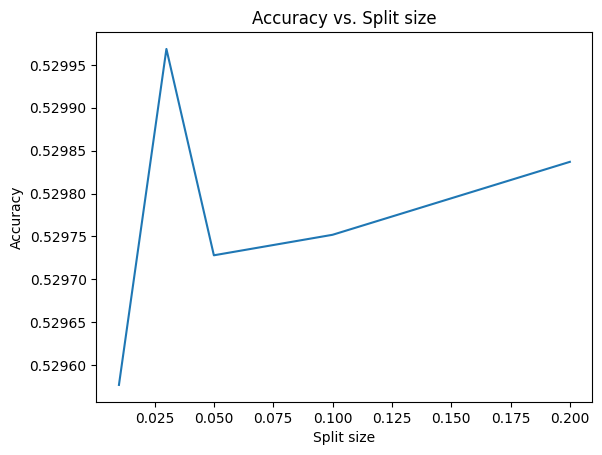

In [ ]:
# prompt: loop through different (set) data splits of real and fake, run logistic regression and compare accuracy
splits = [0.2, 0.1, 0.05, 0.03, 0.01]
accuracies = []

for split in splits:
  train, test = membershipInferenceData(real, fake1_normalized_amounts, test_size=split)
  res = log_reg(train, test)
  accuracies.append(res)
  print(f"split: {split}, accuracy: {res}")

plt.plot(splits, accuracies)
plt.xlabel('Split size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Split size')
plt.show()

### Results from CT

In [ ]:
ct_train, ct_test = membershipInferenceData(real, ct)

In [ ]:
log_reg(ct_train, ct_test)

Accuracy of the classifier: 0.5161139015381008


0.5161139015381008

In [ ]:
rand_forest(ct_train, ct_test)

Accuracy of the classifier: 0.7507622100181758


0.7507622100181758

In [ ]:
xgboost_eval(ct_train, ct_test)

Accuracy of the classifier: 0.7317729200461235


0.7317729200461235

In [ ]:
def different_splits(real, fake, classifier, splits):
  # prompt: loop through different (set) data splits of real and fake, run logistic regression and compare accuracy
  accuracies = []

  for split in splits:
    train, test = membershipInferenceData(real, fake, test_size=split)
    res = classifier(train, test)
    accuracies.append(res)
    print(f"split: {split}, accuracy: {res}")

  return accuracies

In [ ]:
splits = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.95]
accs = different_splits(real, ct, xgboost_eval, splits)

Accuracy of the classifier: 0.7320807356303868
split: 0.2, accuracy: 0.7320807356303868
Accuracy of the classifier: 0.7317102168715514
split: 0.3, accuracy: 0.7317102168715514
Accuracy of the classifier: 0.7308006136767838
split: 0.4, accuracy: 0.7308006136767838
Accuracy of the classifier: 0.7295522504739382
split: 0.5, accuracy: 0.7295522504739382
Accuracy of the classifier: 0.7273918410954977
split: 0.6, accuracy: 0.7273918410954977
Accuracy of the classifier: 0.7282190809366528
split: 0.7, accuracy: 0.7282190809366528
Accuracy of the classifier: 0.7283887808548478
split: 0.8, accuracy: 0.7283887808548478
Accuracy of the classifier: 0.7243313290032856
split: 0.9, accuracy: 0.7243313290032856
Accuracy of the classifier: 0.7239555866415783
split: 0.92, accuracy: 0.7239555866415783
Accuracy of the classifier: 0.720216977842421
split: 0.95, accuracy: 0.720216977842421


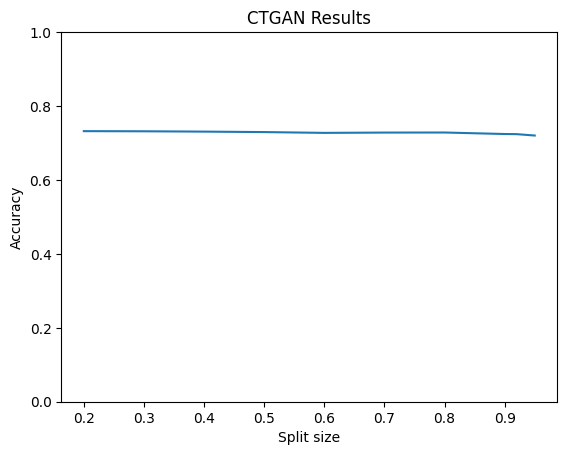

In [ ]:
plt.plot(splits, accs)
plt.ylim(0, 1)
plt.xlabel('Split size')
plt.ylabel('Accuracy')
plt.title('CTGAN Results')
plt.show()

In [ ]:
def split_oneReal(real_df, fake_df, test_size=0.2):

  # take 1 accounts transactions from real (account_id = 1) as real_train
  real_train = real_df[real_df['account_id'] == 1]
  real_test = real_df[real_df['account_id'] != 1]

  # stratify guarantees no same persons transactions are in train vs test sets
  fake_train, fake_test = train_test_split(fake_df, test_size=test_size, stratify=fake_df['account_id'])

  real_train['label'] = 0
  real_test['label'] = 0
  fake_train['label'] = 1
  fake_test['label'] = 1

  train = pd.concat([real_train, fake_train], axis=0)
  test = pd.concat([real_test, fake_test], axis=0)

  train= train[pd.to_datetime(train['date'], dayfirst=True, errors='coerce').notnull()]
  test= test[pd.to_datetime(test['date'], dayfirst=True, errors='coerce').notnull()]
  train['date'] = pd.to_datetime(train['date'], dayfirst=True).astype('int64')
  test['date'] = pd.to_datetime(test['date'], dayfirst=True).astype('int64')

  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)

  train = pd.get_dummies(train, columns=['type', 'operation', 'k_symbol'])
  test = pd.get_dummies(test, columns=['type', 'operation', 'k_symbol'])

  train.drop(columns=['account_id'], inplace=True)
  test.drop(columns=['account_id'], inplace=True)

  return train, test

<ipython-input-93-ef232b8adfb9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-93-ef232b8adfb9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

Accuracy of the classifier: 0.8420671162130936
Accuracy of the classifier: 0.15795919636599362


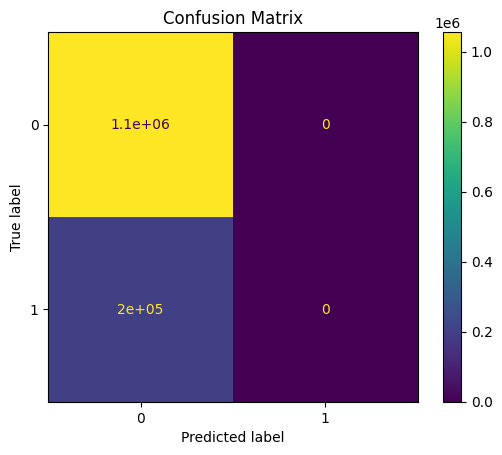

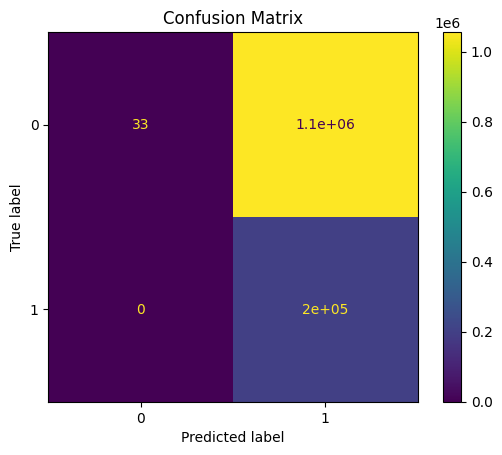

In [ ]:
train, test = split_oneReal(real, ct)
res = []
res.append(log_reg(train, test))
res+= xgboost_eval(train, test)

In [ ]:
def split_n_accounts(real_df, fake_df, n):

  # take the first n accounts to be real_train
  real_train = real_df[real_df['account_id'].isin(real_df['account_id'].unique()[:n])]
  real_test = real_df[real_df['account_id'].isin(real_df['account_id'].unique()[n:])]

  # take the first n unique account_id to be fake_train
  fake_train = fake_df[fake_df['account_id'].isin(fake_df['account_id'].unique()[:n])]
  fake_test = fake_df[fake_df['account_id'].isin(fake_df['account_id'].unique()[n:])]

  real_train['label'] = 0
  real_test['label'] = 0
  fake_train['label'] = 1
  fake_test['label'] = 1

  train = pd.concat([real_train, fake_train], axis=0)
  test = pd.concat([real_test, fake_test], axis=0)

  train= train[pd.to_datetime(train['date'], dayfirst=True, errors='coerce').notnull()]
  test= test[pd.to_datetime(test['date'], dayfirst=True, errors='coerce').notnull()]
  train['date'] = pd.to_datetime(train['date'], dayfirst=True).astype('int64')
  test['date'] = pd.to_datetime(test['date'], dayfirst=True).astype('int64')

  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)

  train = pd.get_dummies(train, columns=['type', 'operation', 'k_symbol'])
  test = pd.get_dummies(test, columns=['type', 'operation', 'k_symbol'])

  train.drop(columns=['account_id'], inplace=True)
  test.drop(columns=['account_id'], inplace=True)

  common_columns = set(train.columns).intersection(test.columns)
  train = train[common_columns]
  test = test[common_columns]

  return train, test

## Membership Inference Results

In [ ]:
final = pd.DataFrame(columns=['Synthetic Dataset', 'Logistic', 'XGBoost'])

<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.516118170266836
Accuracy of the classifier: 0.5560106538950249


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.5160838476812771
Accuracy of the classifier: 0.6202170532019994


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.5161084834062889
Accuracy of the classifier: 0.6379794745243201


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.5161424488652834
Accuracy of the classifier: 0.6554498820185013


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.48231520770788794
Accuracy of the classifier: 0.6354829416807829


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.48256856424055433
Accuracy of the classifier: 0.6461780166313116


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.4826940491783463
Accuracy of the classifier: 0.6529476689923571


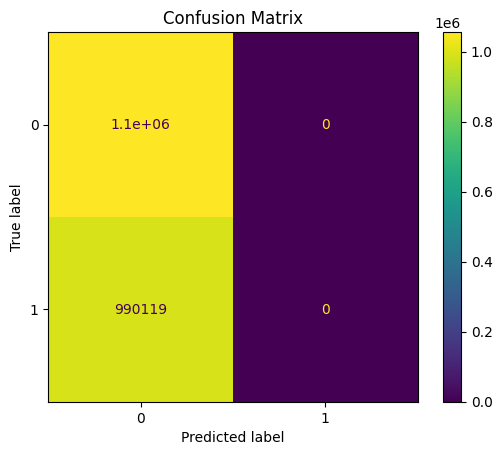

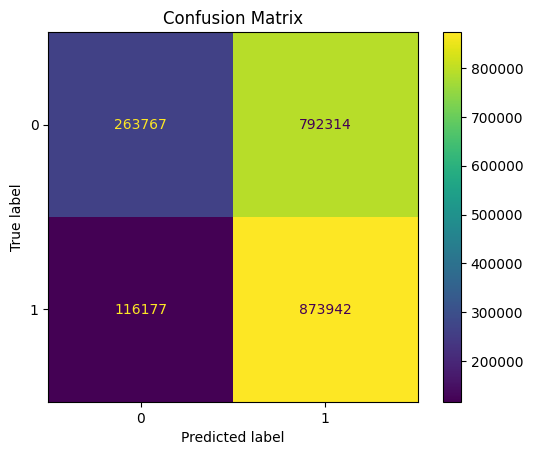

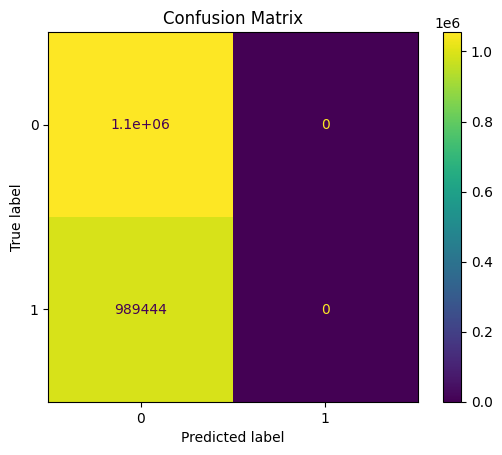

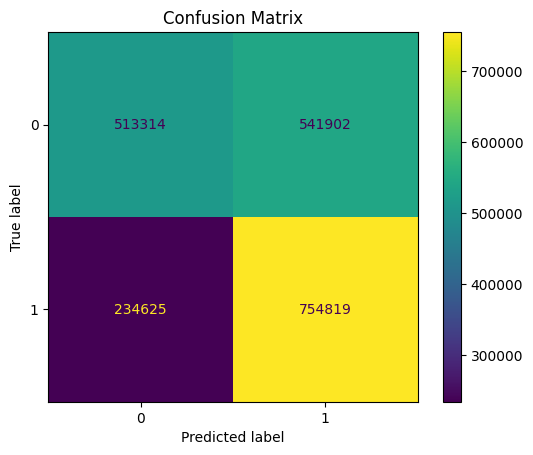

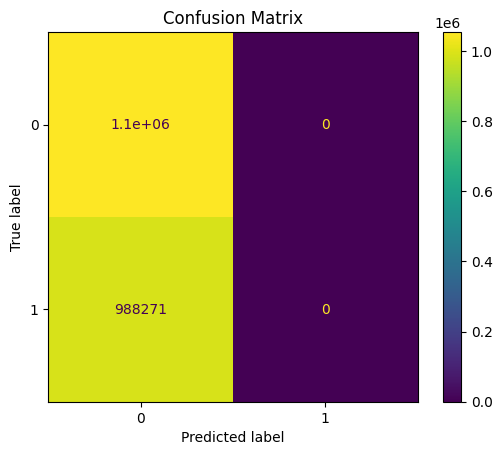

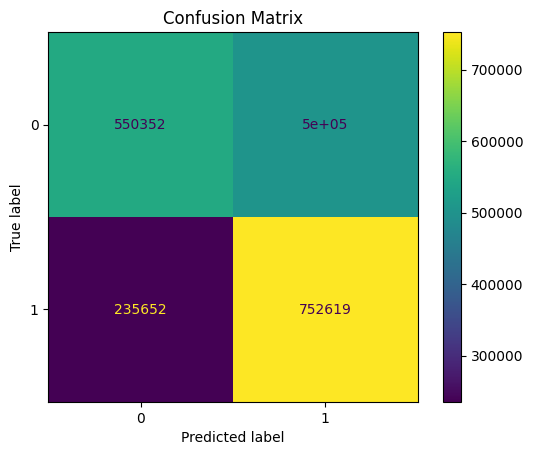

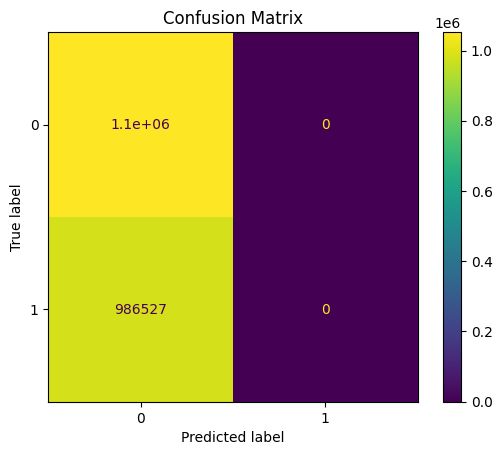

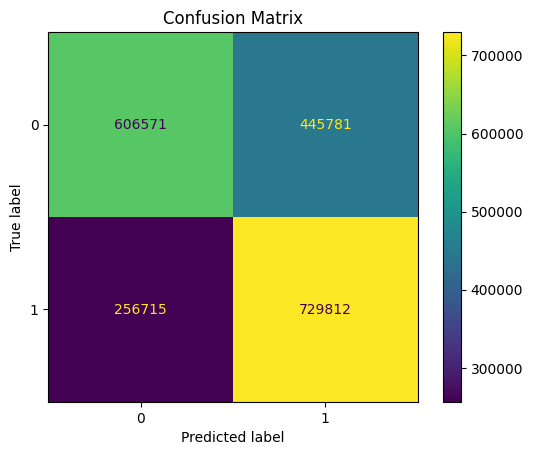

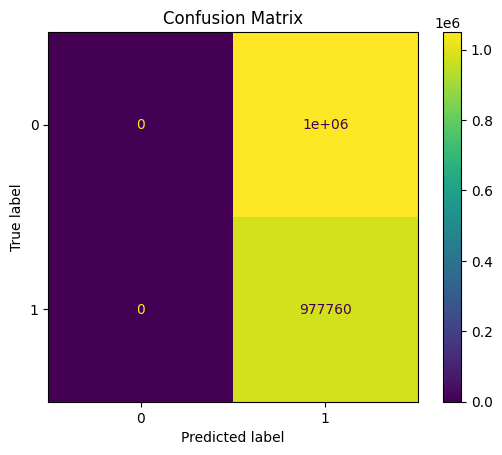

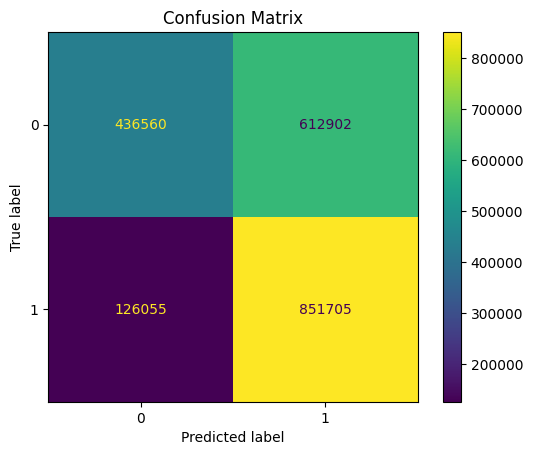

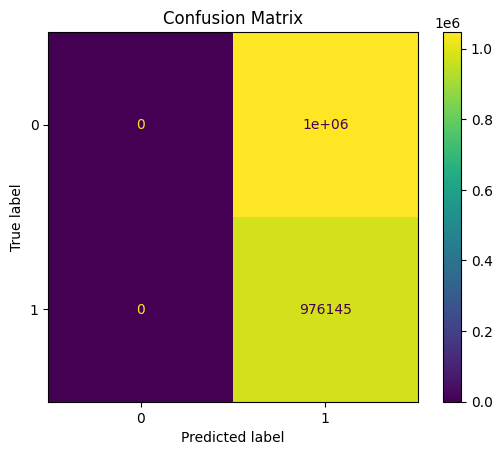

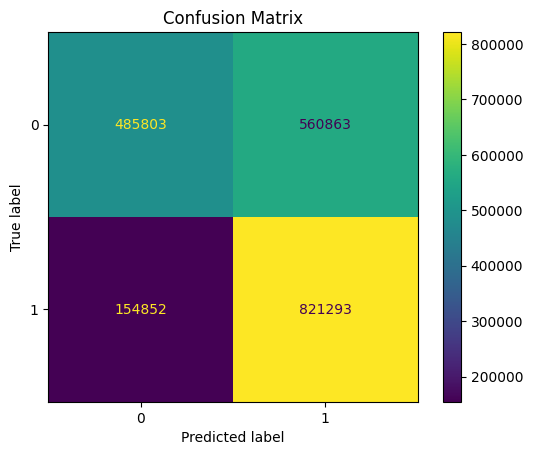

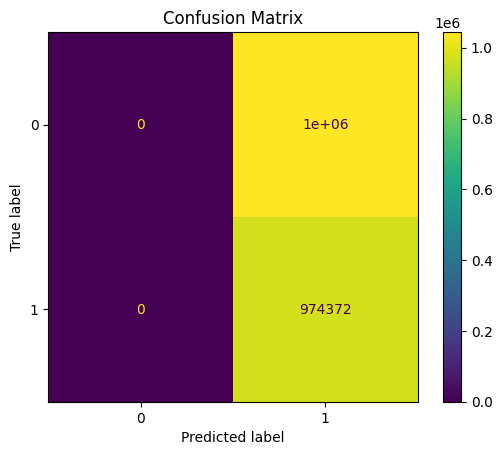

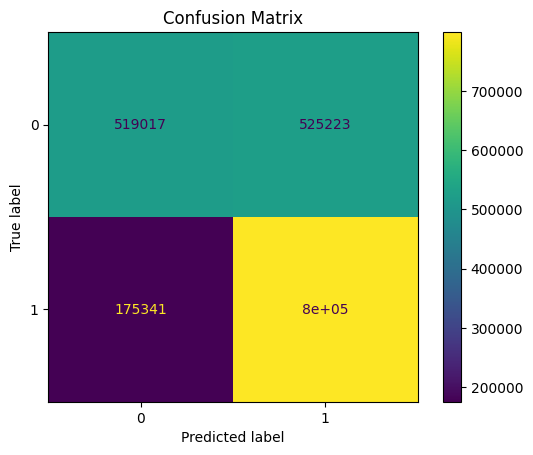

In [ ]:
n_values = [1, 5, 10, 20, 30, 40, 50]
ct_log_reg_accs = []
ct_xgb_accs = []

for n in n_values:
  train, test = split_n_accounts(real, ct, n)
  ct_log_reg_accs.append(log_reg(train, test))
  ct_xgb_accs.append(xgboost_eval(train, test))

final.loc[len(final)] = ['CTGAN', np.mean(ct_log_reg_accs), np.mean(ct_xgb_accs)]

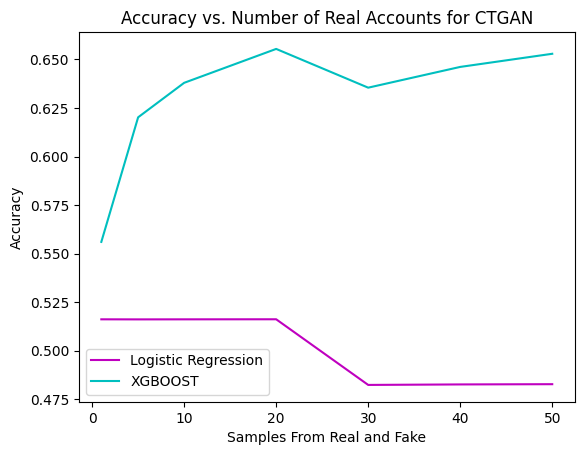

In [ ]:
# prompt: plot Samples From Real and Fake as x axis, accuracy as y axis. x axis should be from n_values, results for Logistic Regression should be from res['log_reg'] and XGBOOST should be from res['xgb

import matplotlib.pyplot as plt
plt.plot(n_values, ct_log_reg_accs,'m', label='Logistic Regression')
plt.plot(n_values, ct_xgb_accs, 'c', label='XGBOOST')
plt.xlabel('Samples From Real and Fake')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Real Accounts for CTGAN')
plt.legend()
plt.show()


### Results from DG

<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.5298424943231932
Accuracy of the classifier: 0.7023180838030141


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.4390460889647555
Accuracy of the classifier: 0.9956998694648057


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.5297875409565809
Accuracy of the classifier: 0.9936469865656886


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.5298441107789225
Accuracy of the classifier: 0.9977398530023351


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.5297495826714379
Accuracy of the classifier: 0.9981726889689473


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.529783645669674
Accuracy of the classifier: 0.9984141911919532


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.5297352084896428
Accuracy of the classifier: 0.9987865561377584


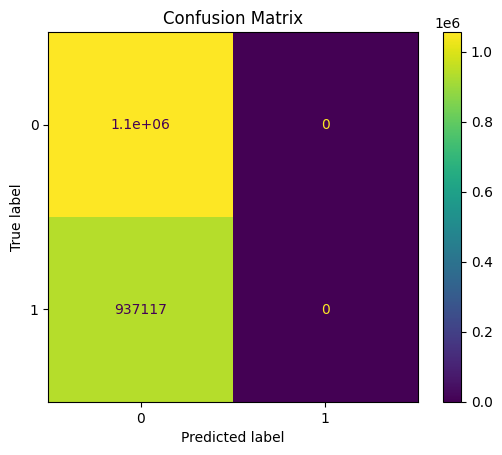

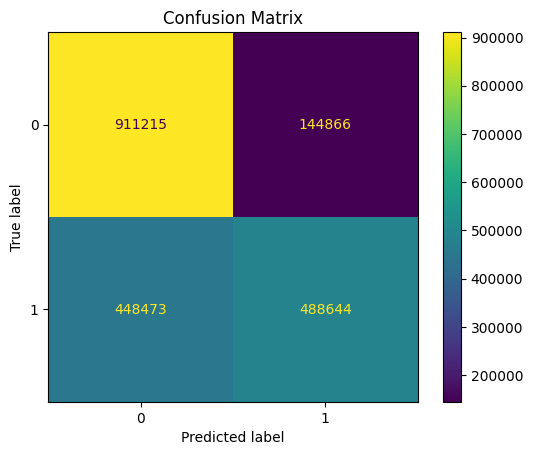

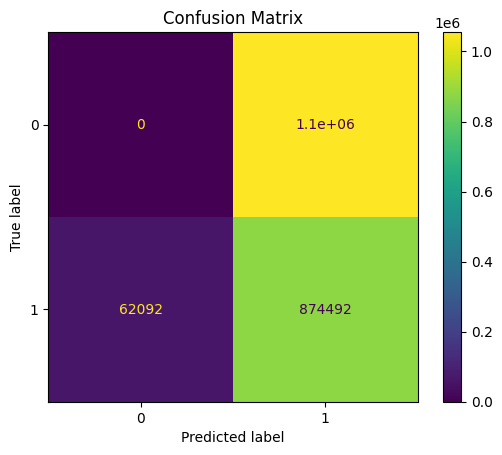

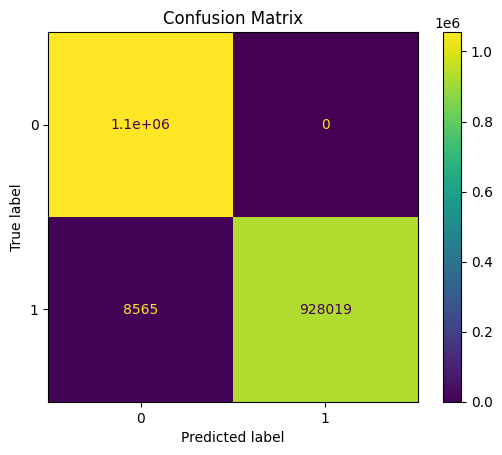

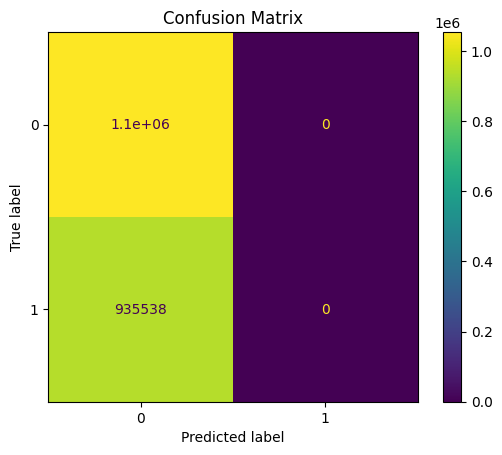

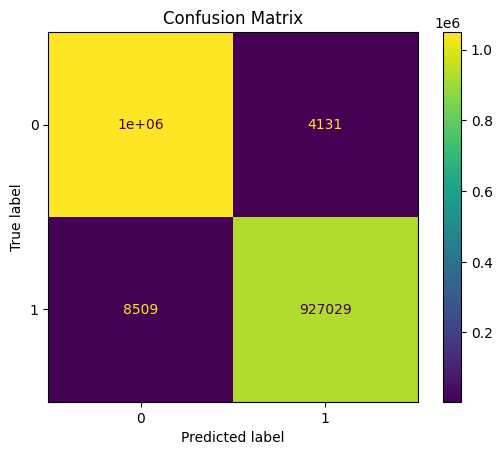

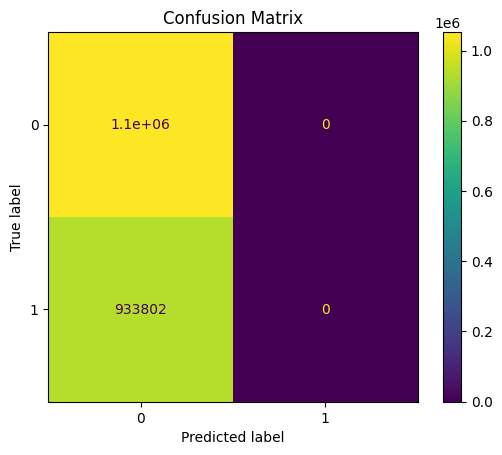

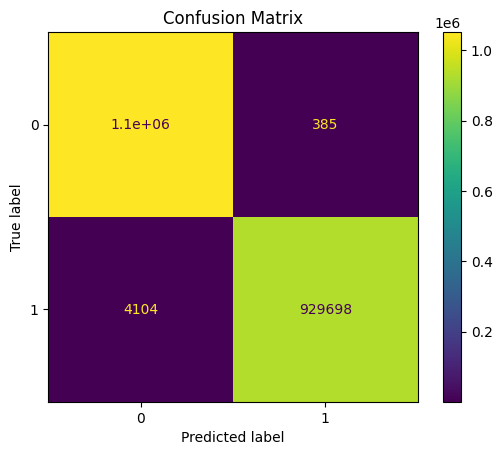

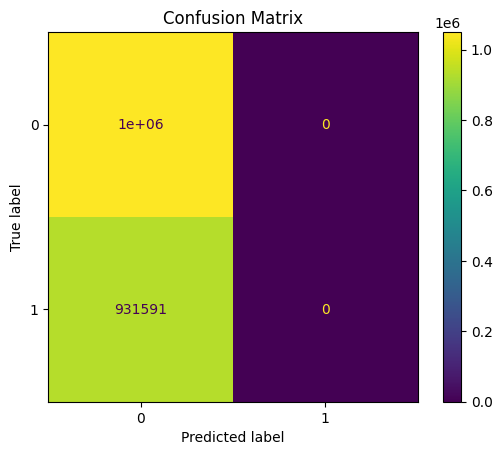

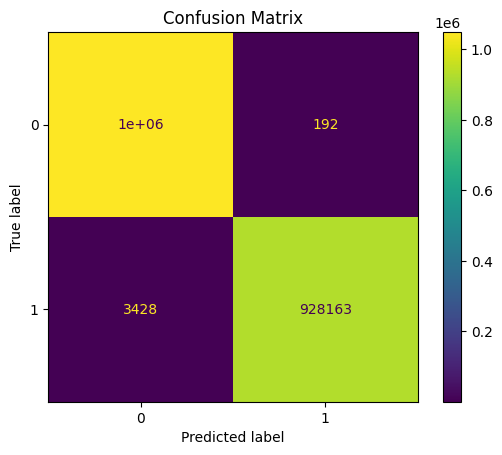

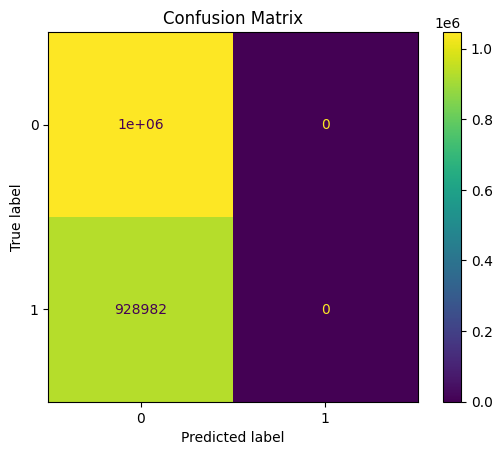

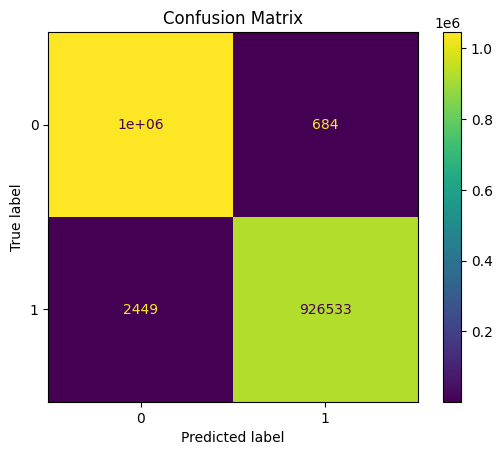

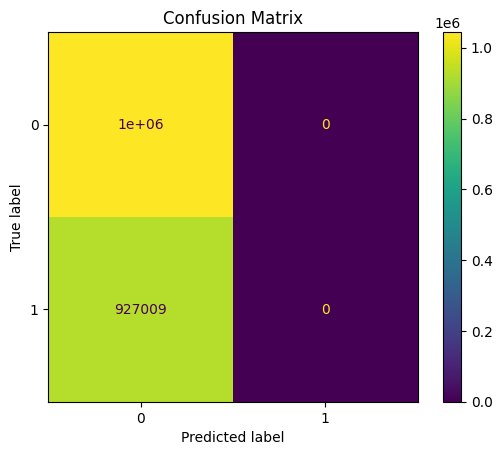

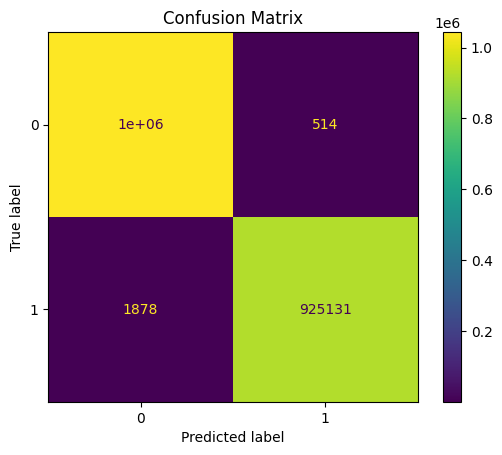

In [ ]:
n_values = [1, 5, 10, 20, 30, 40, 50]
dg_log_reg_accs = []
dg_xgb_accs = []

for n in n_values:
  train, test = split_n_accounts(real, dg, n)
  dg_log_reg_accs.append(log_reg(train, test))
  dg_xgb_accs.append(xgboost_eval(train, test))

final.loc[len(final)] = ['DoppelGANger', np.mean(dg_log_reg_accs), np.mean(dg_xgb_accs)]

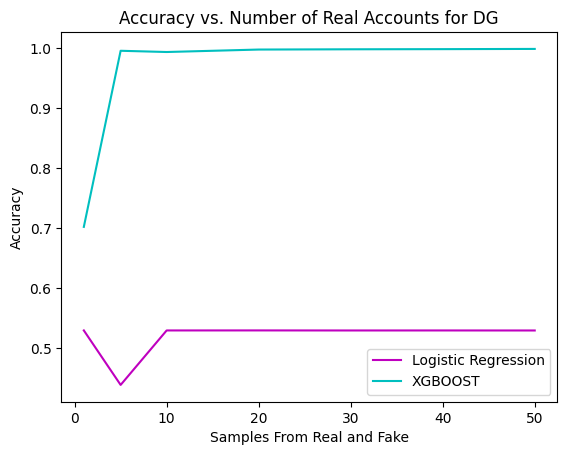

In [ ]:
plt.plot(n_values, dg_log_reg_accs,'m', label='Logistic Regression')
plt.plot(n_values, dg_xgb_accs, 'c', label='XGBOOST')
plt.xlabel('Samples From Real and Fake')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Real Accounts for DG')
plt.legend()
plt.show()


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.7458193885456296
Accuracy of the classifier: 0.7181195493506007


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.7458326736480221
Accuracy of the classifier: 0.9053657860810169


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.7458374874139319
Accuracy of the classifier: 0.9153176076175166


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.7459510955859003
Accuracy of the classifier: 0.9200157079344917


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.7458534165516516
Accuracy of the classifier: 0.9241639671883684


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.7457722524093922
Accuracy of the classifier: 0.9252436468001363


<ipython-input-121-0a60d3e62831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_train['label'] = 0
<ipython-input-121-0a60d3e62831>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['label'] = 0
<ipython-input-121-0a60d3e62831>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Accuracy of the classifier: 0.745757870079415
Accuracy of the classifier: 0.9238773353139462


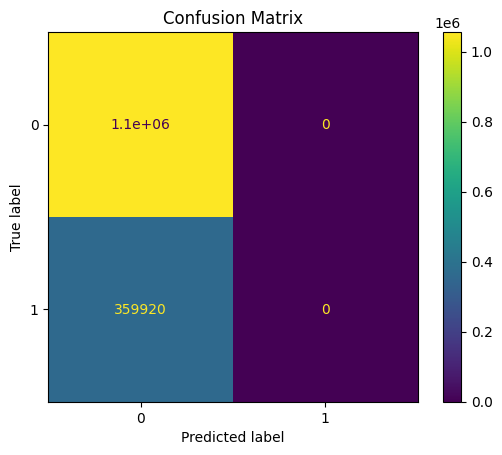

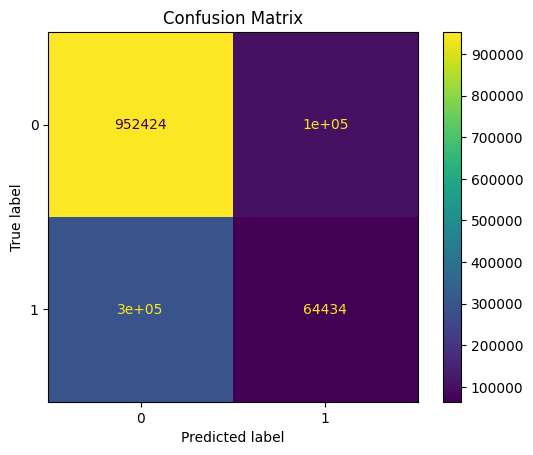

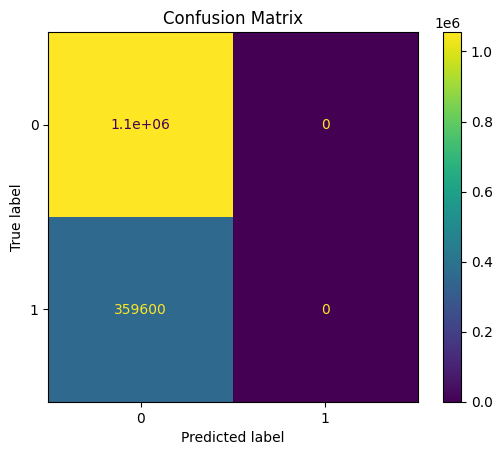

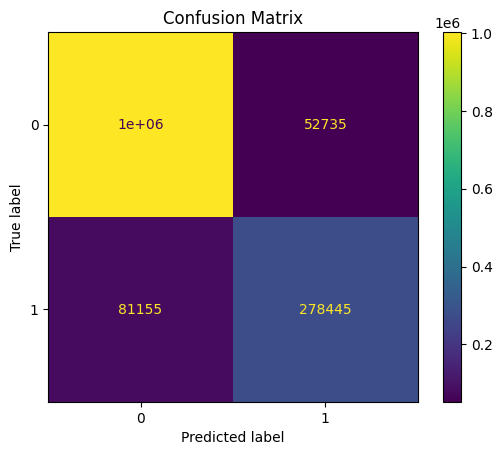

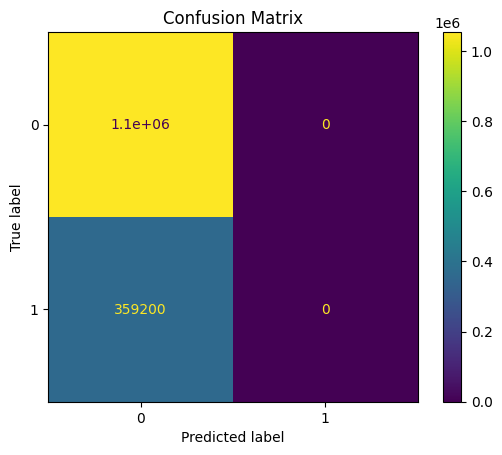

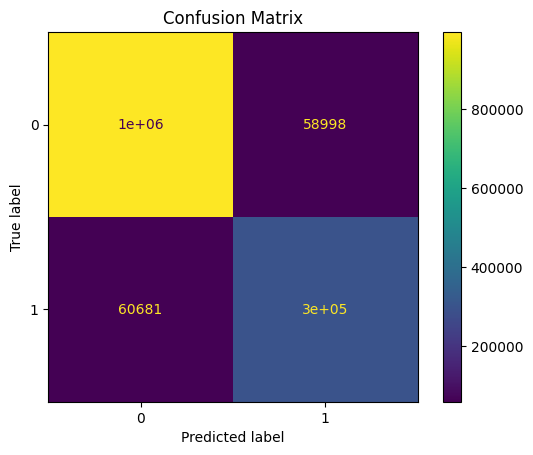

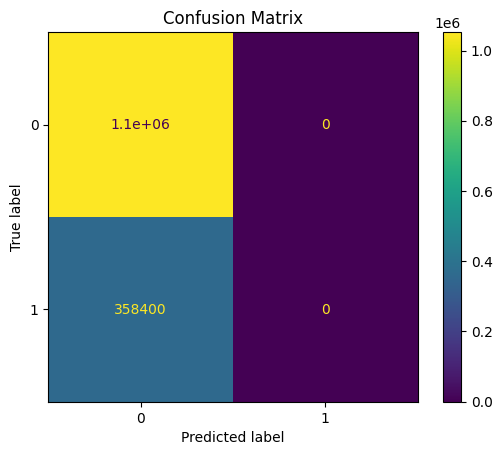

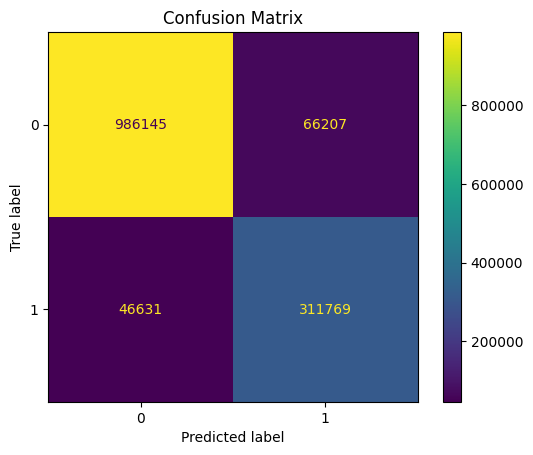

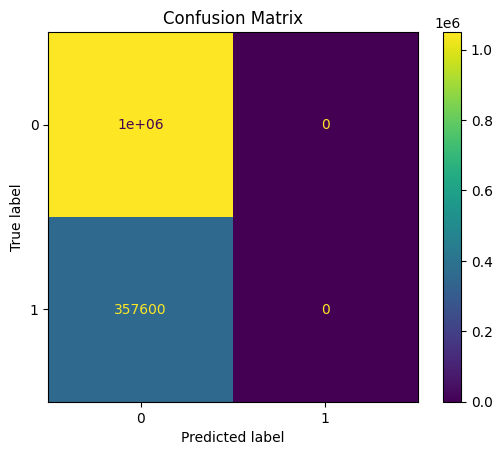

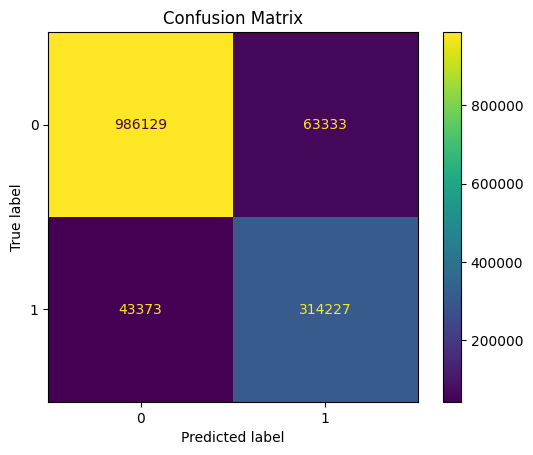

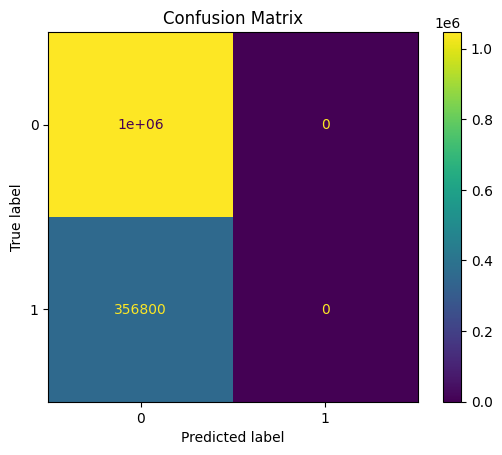

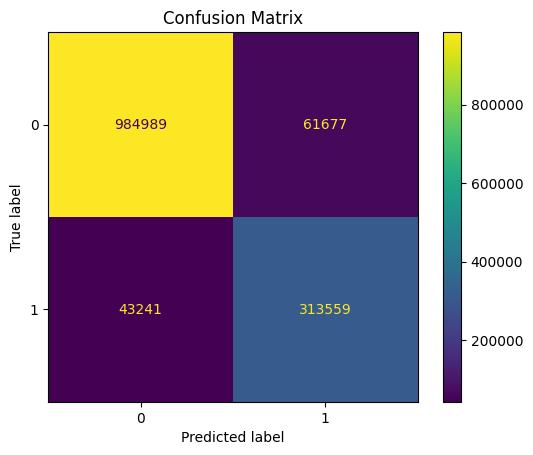

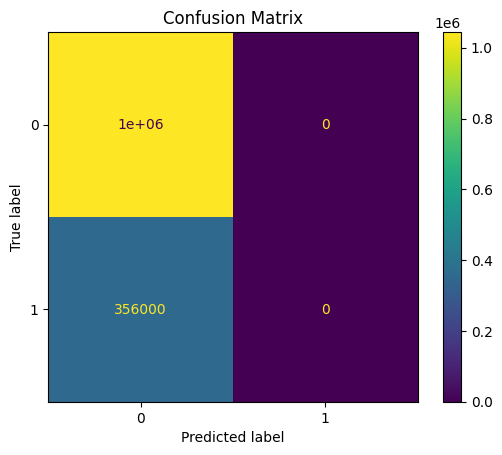

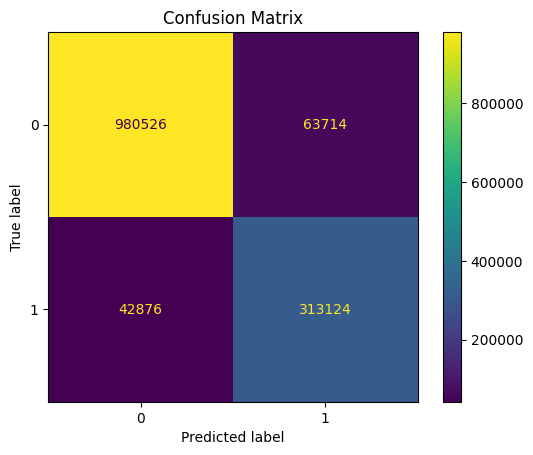

In [ ]:
n_values = [1, 5, 10, 20, 30, 40, 50]
bf_log_reg_accs = []
bf_xgb_accs = []

for n in n_values:
  train, test = split_n_accounts(real, bf, n)
  bf_log_reg_accs.append(log_reg(train, test))
  bf_xgb_accs.append(xgboost_eval(train, test))

final.loc[len(final)] = ['Banksformer', np.mean(bf_log_reg_accs), np.mean(bf_xgb_accs)]

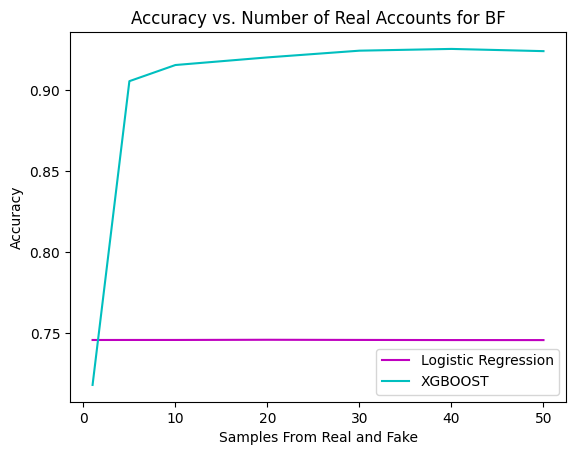

In [ ]:
plt.plot(n_values, bf_log_reg_accs,'m', label='Logistic Regression')
plt.plot(n_values, bf_xgb_accs, 'c', label='XGBOOST')
plt.xlabel('Samples From Real and Fake')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Real Accounts for BF')
plt.legend()
plt.show()


In [ ]:
final

,Synthetic Dataset,Logistic,XGBoost
0,CTGAN,0.501719,0.629181
1,DoppelGANger,0.516827,0.954968
2,Banksformer,0.745832,0.890301


## Distance metrics

### kNN with Cosine

In [ ]:
def amount_sign(amount_no_sign, amount_sign):
    """ Add signs to transaction amount. Withdrawal = negative, credit = positive"""
    amount_with_sign = []
    for amount, sign in zip(amount_no_sign, amount_sign):
        if sign == 'WITHDRAWAL':
            amount_with_sign.append(amount*-1)
        elif sign == 'CREDIT':
            amount_with_sign.append(amount)
        else:
            amount_with_sign.append(0)
    return amount_with_sign

In [ ]:
def get_trans_profile(df):
    """ Calculate transaction profile vectors"""
    # Uniqie categories under k_symbol
    template_trans_profile = pd.DataFrame(real['k_symbol'].unique(), columns = ['k_symbol'])
    # For each account, sum up transaction amount for each category to obtain transaction profile vectors
    for account in tqdm(sorted(df.account_id.unique())):
        sub = df[df['account_id'] == account]
        if sub.shape[0] != 0:
            _ = sub.groupby('k_symbol', dropna = False)['amount_2'].sum().reset_index()
            template_trans_profile = pd.merge(template_trans_profile, _, how = 'left', on = 'k_symbol')
    print(template_trans_profile.shape)
    template_trans_profile = template_trans_profile.set_index('k_symbol').transpose().reset_index().drop(columns = ['index'])
    print(template_trans_profile.shape)
    return template_trans_profile

In [ ]:
real['amount_2'] = amount_sign(real['amount'], real['type'])
fake1['amount_2'] = amount_sign(fake1['amount'], fake1['type'])

In [ ]:
# Step 1. Get transaction profile vectors
# get real trans profile
real_trans_profile_2 = get_trans_profile(real)
real_trans_profile_2 = real_trans_profile_2.fillna(0)
real_trans_profile_2.head()

  0%|          | 0/190 [00:00<?, ?it/s]<ipython-input-48-1447840b8ab9>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'amount_2_x'} in the result is deprecated and will raise a MergeError in a future version.
  template_trans_profile = pd.merge(template_trans_profile, _, how = 'left', on = 'k_symbol')
<ipython-input-48-1447840b8ab9>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'amount_2_x'} in the result is deprecated and will raise a MergeError in a future version.
  template_trans_profile = pd.merge(template_trans_profile, _, how = 'left', on = 'k_symbol')
<ipython-input-48-1447840b8ab9>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'amount_2_x'} in the result is deprecated and will raise a MergeError in a future version.
  template_trans_profile = pd.merge(template_trans_profile, _, how = 'left', on = 'k_symbol')
  5%|▍         | 9/190 [00:00<00:02, 87.55it/s]<ipython-input-48-1447840b8ab9>:10: FutureWarning: Passi

(9, 191)
(190, 9)


k_symbol,nan,INTEREST CREDITED,PAYMENT ON STATEMENT,HOUSEHOLD,LOAN PAYMENT,,INSURANCE PAYMENT,OLD AGE PENSION,SANCTION INTEREST
0,191255.0,3065.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1586336.0,10717.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,170989.0,2070.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,800.0,2744.0,0.0,0.0,0.0,0.0,0.0,188802.0,0.0
4,600.0,1562.0,0.0,0.0,0.0,0.0,0.0,95323.0,0.0


In [ ]:
# get BF trans profile
BF_trans_profile_2 = get_trans_profile(fake1)
BF_trans_profile_2 = BF_trans_profile_2.fillna(0)
BF_trans_profile_2.head()

  0%|          | 0/191 [00:00<?, ?it/s]<ipython-input-56-95c8f39aac83>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'amount_2_x'} in the result is deprecated and will raise a MergeError in a future version.
  template_trans_profile = pd.merge(template_trans_profile, _, how = 'left', on = 'k_symbol')
<ipython-input-56-95c8f39aac83>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'amount_2_x'} in the result is deprecated and will raise a MergeError in a future version.
  template_trans_profile = pd.merge(template_trans_profile, _, how = 'left', on = 'k_symbol')
<ipython-input-56-95c8f39aac83>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'amount_2_x'} in the result is deprecated and will raise a MergeError in a future version.
  template_trans_profile = pd.merge(template_trans_profile, _, how = 'left', on = 'k_symbol')
<ipython-input-56-95c8f39aac83>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'a

(9, 192)
(191, 9)


k_symbol,nan,INTEREST CREDITED,PAYMENT ON STATEMENT,HOUSEHOLD,LOAN PAYMENT,,INSURANCE PAYMENT,OLD AGE PENSION,SANCTION INTEREST
0,872803.0,6813.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103010.0,2236.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,131459.0,2204.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,290697.0,5055.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,416617.5,6001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Step 2. Build KNN
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors = 1,
                         metric = 'cosine')
                         #algorithm = 'brute')
model.fit(real_trans_profile_2.values) # fit on real

NearestNeighbors(metric='cosine', n_neighbors=1)

Ideally, we want the mean distance to be as small as possible. This indicates that the synthetic transaction profiles in BF_trans_profile_2 are, on average, close to real transaction profiles in the training data.

The mean distance provides a measure of how well the synthetic transaction profiles represent the real transaction profiles. A lower mean distance suggests that the synthetic profiles are more realistic and representative of real-world data.

In [ ]:
# Step 3. For each synthetic account, find the closest cosine distance to the real transaction profile
BF_result = model.kneighbors(BF_trans_profile_2, n_neighbors = 1, return_distance = True)
# Step 4. Get average distance
# print(BF_result[0])
print(BF_result[0].mean())

3.2326035643290156e-07


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


### Privacy Metric

In [ ]:
def distribution_divergence(real, fake, cts_cols = ['amount'], cat_cols = ['type', 'operation', 'k_symbol']):
    """
    Calculates Wasserstein's Distance for continuous columns and Jensen-Shannon Divergence for categorical columns.
    Inputs:
        real -> DataFrame for real data
        fake -> DataFrame for fake data
        cts_cols -> a list of continuous columns
        cat_cols -> a list of categorical columns
        """
    cts_div = []
    cat_div = []
    for col in real.columns:
        if col in cts_cols: # For continuous columns
            # CTAB-GAN: scaling values between 0 and 1 to obtained normalized statistical similarity
            scaler = MinMaxScaler()
            scaler.fit(real[col].values.reshape(-1, 1))
            real_ = scaler.transform(real[col].values.reshape(-1, 1)).flatten()
            fake_ = scaler.transform(fake[col].values.reshape(-1, 1)).flatten()
            # calculate wasserstein distance
            cts_div.append((col, wasserstein_distance(real_, fake_)))
        elif col in cat_cols: # For categorical columns
            # 1. compute pmf for the categorical column
            temp = pd.DataFrame()
            temp['index'] = real[col].unique()
            # use merge to handle order
            real_pmf = pd.DataFrame(real[col].value_counts(normalize = True, dropna = False)).reset_index()
            temp = pd.merge(temp, real_pmf, how = 'outer', on = 'index')
            fake_pmf = pd.DataFrame(fake[col].value_counts(normalize = True, dropna = False)).reset_index()
            temp = pd.merge(temp, fake_pmf, how = 'outer', on = 'index')
            print(temp)
            # If a category of a column is not generated in the synthetic dataset, pmf of zero is assigned
            temp = temp.fillna(0)
            # 3. compute the square of JS distance
            cat_div.append((col, spatial.distance.jensenshannon(temp[temp.columns[1]], temp[temp.columns[2]])**2))
    return cat_div, cts_div

In [ ]:
transactions = pd.read_csv('https://raw.githubusercontent.com/BigTuna08/Banksformer_ecml_2022/main/czech/banksformer/data/tr_by_acct_w_age.csv',
                           parse_dates=['date'])
transactions = transactions[['account_id', 'type', 'operation', 'amount', 'k_symbol']]
transactions = transactions.fillna('nan')
cts_cols = ['amount']
cat_cols = ['type', 'operation', 'k_symbol']

transactions.head()

,account_id,type,operation,amount,k_symbol
0,1,CREDIT,CREDIT IN CASH,1000.0,nan
1,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,nan
2,1,CREDIT,CREDIT IN CASH,12600.0,nan
3,1,CREDIT,nan,19.2,INTEREST CREDITED
4,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,nan


In [ ]:
real = transactions[transactions['account_id'] <= 200].copy()
fake2 = transactions[(201 <= transactions['account_id']) & (transactions['account_id'] <= 400)].copy()
# reset indices of fake1
fake2 = fake2.reset_index(drop = True)

real.head()
fake2.head()

,account_id,type,operation,amount,k_symbol
0,201,CREDIT,CREDIT IN CASH,600.0,nan
1,201,CREDIT,CREDIT IN CASH,15835.0,nan
2,201,CREDIT,nan,47.9,INTEREST CREDITED
3,201,CREDIT,CREDIT IN CASH,4300.0,nan
4,201,CREDIT,CREDIT IN CASH,23752.0,nan


In [ ]:
cat_div_all = []
cts_div_all = []
labels = ['Second 200']
for i, row in tqdm(enumerate(fake2.iterrows())):
    print(labels[i])
    # for each synthetic dataset, calculate distribution metrics
    cat_div, cts_div = distribution_divergence(real = real,
                                               fake = pd.DataFrame(row),
                                               cts_cols = ['amount'],
                                               cat_cols = ['type', 'operation', 'k_symbol'])
    cat_div_all.append(cat_div)
    cts_div_all.append(cts_div)

0it [00:00, ?it/s]

Second 200


KeyError: 'type'

In [ ]:

def compute_kl_divergence(p, q):
    """
    Compute KL divergence between two distributions.
    """
    return entropy(p, qk=q)

def generate_synthetic_data(n_samples, n_features):
    """
    Generate synthetic data (e.g., using GANs).
    """
    # Generate synthetic data using GANs or any other method
    return np.random.randn(n_samples, n_features)

def estimate_expected_privacy_loss(data, removed_example, k):
    """
    Estimate the expected privacy loss using high-dimensional KL divergence estimator.
    """
    tree = KDTree(data)
    distances, _ = tree.query(data[removed_example], k=k+1)
    neighbors_indices = np.argwhere(np.isin(data, data[distances < distances[-1]]))
    removed_example_data = data[removed_example]
    removed_example_neighbors = data[neighbors_indices]
    kl_divergences = [compute_kl_divergence(removed_example_data, neighbor) for neighbor in removed_example_neighbors]
    return np.mean(kl_divergences)

def chebyshev_bound(prob_threshold, expected_privacy_loss, delta):
    """
    Apply Chebyshev's inequality to bound the probability of the expected privacy loss exceeding a predefined threshold.
    """
    z_score = norm.ppf(1 - prob_threshold)
    bound = expected_privacy_loss + z_score * np.sqrt(np.log(1/delta))
    return bound



In [ ]:
# Example usage
n_samples = 1000
n_features = 10
data = generate_synthetic_data(n_samples, n_features)
removed_example_index = np.random.randint(0, n_samples)
k = 5  # Number of nearest neighbors
expected_privacy_loss = estimate_expected_privacy_loss(data, removed_example_index, k)
prob_threshold = 0.01
delta = 0.05
bound = chebyshev_bound(prob_threshold, expected_privacy_loss, delta)

print(f"Expected Privacy Loss: {expected_privacy_loss}")
print(f"Chebyshev Bound: {bound}")

## Gaussian NB

In [ ]:
!pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
def gaussian_niave_bayes(train, test):
  from diffprivlib.models import GaussianNB
  epsilon = 1.0
  sensitivity = 1.0  # Sensitivity depends on the maximum change in the model's output for a single change in the input data

  X_train = train.drop(columns=['label'])
  y_train = train['label']
  X_test = test.drop(columns=['label'])
  y_test = test['label']

  # Initialize and train the differentially private classifier
  # clf = GaussianNB(epsilon=epsilon)
  # clf.fit(X_train, y_train)
  # y_pred = clf.predict(X_test)
  # accuracy = accuracy_score(y_test, y_pred)
  # print("Accuracy of the differentially private classifier:", accuracy)
  epsilons = np.logspace(-2, 2, 50)
  accuracy = list()

  for epsilon in epsilons:
      clf = GaussianNB(epsilon=epsilon)
      clf.fit(X_train, y_train)

      accuracy.append(clf.score(X_test, y_test))

  plt.semilogx(epsilons, accuracy)
  plt.title("Differentially private Naive Bayes accuracy")
  plt.xlabel("epsilon")
  plt.ylabel("Accuracy")
  plt.show()

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be 

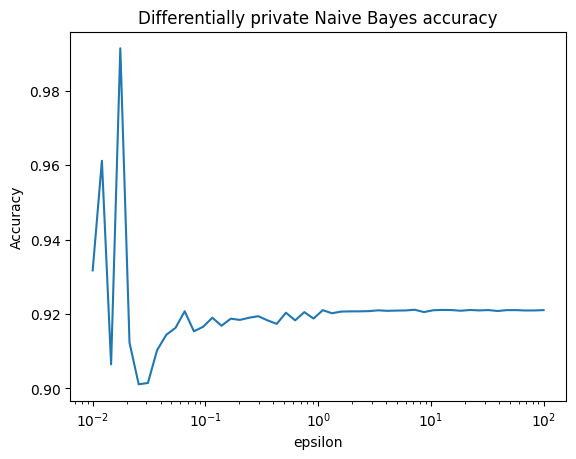

In [ ]:
gaussian_niave_bayes(train1, test1)

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be 

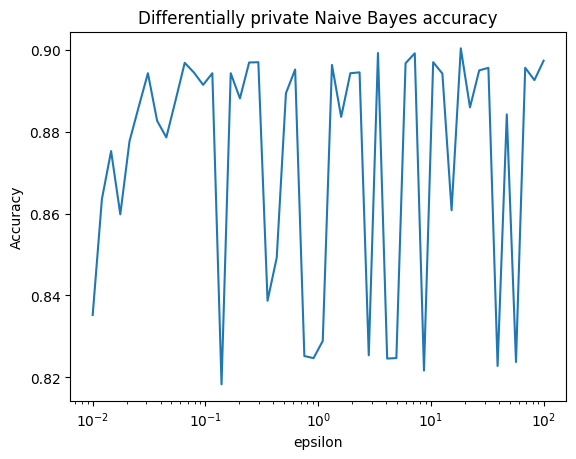

In [ ]:
gaussian_niave_bayes(train2, test2)

# Re-identification Risk


To assess the re-identification risk between a real and synthetic dataframe, we can calculate the overlap in the categorical distributions of 'operation', 'type', and 'k_symbol' columns, as well as the similarity in the numerical distribution of the 'amount' column. A basic approach to assess this risk is to:

- Compare the frequency distributions of the categorical variables between the real and synthetic data.
- Assess the similarity of the 'amount' distribution using a simple statistical distance or overlap measure.

This code performs a basic comparison of the distributions in the categorical columns and uses the Kolmogorov-Smirnov (KS) test to compare the distribution of the 'amount' column between the real and synthetic dataframes. The KS statistic provides a measure of the maximum distance between the empirical distribution functions of the two samples, and the P-value indicates the significance of this difference. A smaller KS statistic and a larger P-value suggest that the two distributions are similar.



In [ ]:
from scipy.stats import ks_2samp

def assess_re_identification_risk(real_df, synthetic_df):
    # Ensure the data does not contain any personally identifiable information (PII) before starting.
    categorical_columns = ['operation', 'type', 'k_symbol']

    print("Categorical Distribution Similarity:")
    for col in categorical_columns:
        real_dist = real_df[col].value_counts(normalize=True)
        synthetic_dist = synthetic_df[col].value_counts(normalize=True)
        overlap = real_dist.to_frame().join(synthetic_dist.to_frame(), lsuffix='_real', rsuffix='_synthetic')
        overlap.fillna(0, inplace=True)
        total_difference = (overlap[col + '_real'] - overlap[col + '_synthetic']).abs().sum() / 2
        print(f"{col} total difference in distribution: {total_difference:.4f}")

    print("\nNumerical Distribution Similarity ('amount'):")
    # Using the Kolmogorov-Smirnov test as an example to compare the 'amount' distributions
    ks_stat, p_value = ks_2samp(real_df['amount'], synthetic_df['amount'])
    print(f"KS statistic: {ks_stat:.4f}, P-value: {p_value:.4f}")

# Example usage:
# Assuming real_df and synthetic_df are your real and synthetic DataFrames loaded beforehand.
# assess_re_identification_risk(real_df, synthetic_df)


In [ ]:
assess_re_identification_risk(real, bf)

Categorical Distribution Similarity:
operation total difference in distribution: 0.2432
type total difference in distribution: 0.3355
k_symbol total difference in distribution: 0.1707

Numerical Distribution Similarity ('amount'):
KS statistic: 0.2726, P-value: 0.0000


In [ ]:
assess_re_identification_risk(real, dg)

Categorical Distribution Similarity:
operation total difference in distribution: 0.4148
type total difference in distribution: 0.3944
k_symbol total difference in distribution: 0.4705

Numerical Distribution Similarity ('amount'):
KS statistic: 0.6687, P-value: 0.0000


In [ ]:
assess_re_identification_risk(real, ct)

Categorical Distribution Similarity:
operation total difference in distribution: 0.1139
type total difference in distribution: 0.0372
k_symbol total difference in distribution: 0.1040

Numerical Distribution Similarity ('amount'):
KS statistic: 0.1183, P-value: 0.0000


In [ ]:
assess_re_identification_risk(real, tvae)

Categorical Distribution Similarity:
operation total difference in distribution: 0.2291
type total difference in distribution: 0.0064
k_symbol total difference in distribution: 0.4717

Numerical Distribution Similarity ('amount'):
KS statistic: 0.0775, P-value: 0.0000


# Statistical Comparison Metrics

## Univariate distributions (categorical)

In [11]:
labels = ['Banksformer', 'DoppelGANger', 'CTGAN', 'TVAE']
fakes = [bf, dg, ct, tvae]

In [12]:
temp = real
temp['source'] = 'Real'
# append all synthetic datasets into one
for i, (df, label) in enumerate(zip(fakes, labels)):
    df['source'] = label
    temp = pd.concat([temp, df], axis = 0)
temp = temp.fillna('None').reset_index()

In [13]:
temp.head()

,index,account_id,date,type,operation,amount,k_symbol,source
0,0,1,1995-03-24 00:00:00,CREDIT,CREDIT IN CASH,1000.0,,Real
1,1,1,1995-04-13 00:00:00,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,,Real
2,2,1,1995-04-23 00:00:00,CREDIT,CREDIT IN CASH,12600.0,,Real
3,3,1,1995-04-30 00:00:00,CREDIT,,19.2,INTEREST CREDITED,Real
4,4,1,1995-05-13 00:00:00,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,,Real


In [14]:
import seaborn as sns

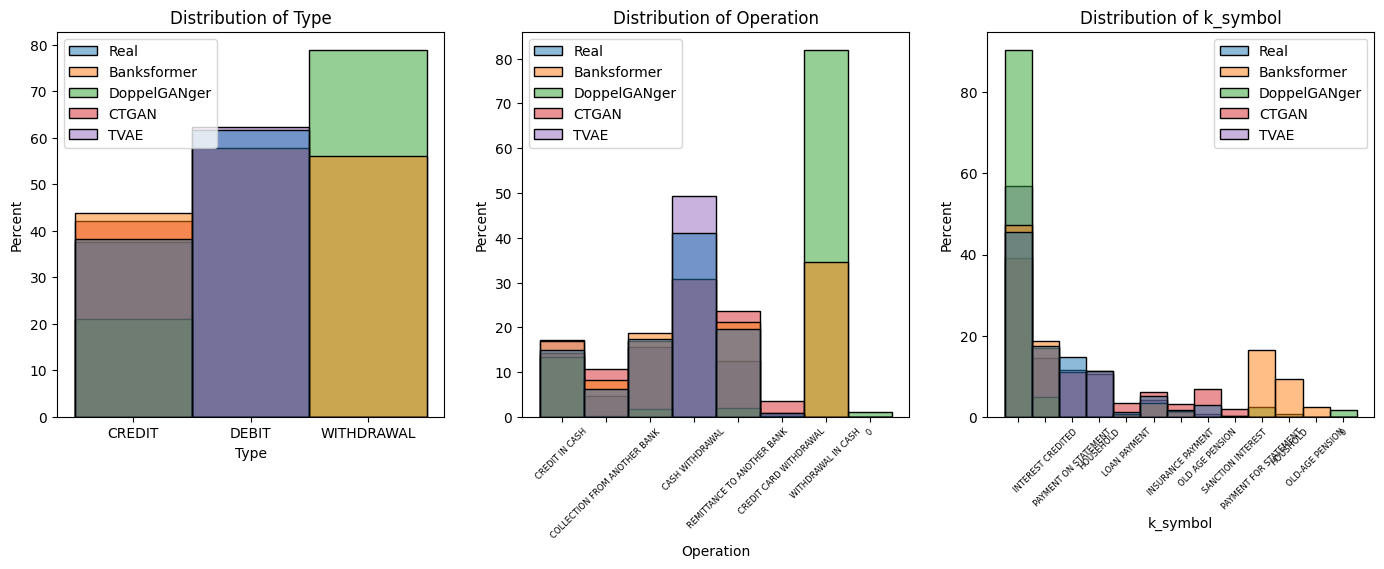

In [15]:
# Plot 3-Gram Comparison
fig, axes = plt.subplots(1, 3, figsize = (17, 5))

# Type
hist = sns.histplot(data = temp,
            x = 'type',
            hue = 'source',
            stat = 'percent',
            common_norm = False,
            ax = axes[0])
axes[0].set_title('Distribution of Type')
axes[0].set_xlabel('Type')
hist.legend_.set_title(None)

# Operation
hist = sns.histplot(data = temp,
            x = 'operation',
            hue = 'source',
            stat = 'percent',
            common_norm = False,
            ax = axes[1])
axes[1].set_title('Distribution of Operation')
axes[1].set_xlabel('Operation')
axes[1].tick_params(axis = 'x', labelsize = 6, rotation = 45)
hist.legend_.set_title(None)

# k_symbol
hist = sns.histplot(data = temp,
            x = 'k_symbol',
            hue = 'source',
            stat = 'percent',
            common_norm = False,
            ax = axes[2])
axes[2].set_title('Distribution of k_symbol')
axes[2].set_xlabel('k_symbol')
axes[2].tick_params(axis = 'x', labelsize = 6, rotation = 45)
hist.legend_.set_title(None)

fig.subplots_adjust(wspace = 0.2)

plt.savefig('Univariate Distributions.tiff', dpi = 300, bbox_inches = 'tight')

## (continuous)

In [33]:
def continuous_histograms(df, save_to, feature = 'amount'):
  for i, col in enumerate([feature]):
      hist = sns.histplot(data=df,
                          x=col,
                          hue='source',
                          stat='probability',
                          common_norm=False,
                          binwidth=100)
      plt.yscale('log')  # Set the y-axis to a log scale

  plt.tight_layout()
  plt.title('Distribution of Amount')
  plt.xlabel('Amount')
  plt.xlim([0, 50000])
  plt.ylim(bottom=1e-4)
  hist.legend_.set_title(None)
  plt.savefig(save_to, dpi=300, bbox_inches='tight')
  plt.clf()

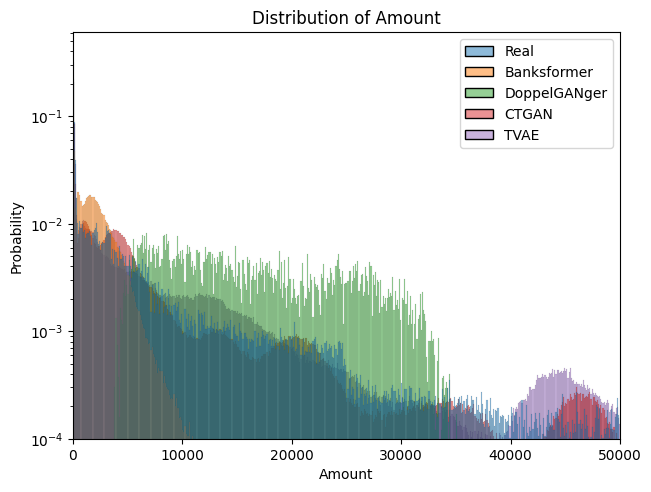

In [26]:
continuous_histograms(temp, 'AmountDistLogScale.jpg')

In [34]:
for i, (df, label) in enumerate(zip(fakes, labels)):
    temp = real
    temp['source'] = 'Real'
    df['source'] = label
    temp = pd.concat([temp, df], axis = 0)
    temp = temp.fillna('None').reset_index()
    save_to = f'AmountDistLogScale_{label}.jpg'
    continuous_histograms(temp, save_to)


<Figure size 640x480 with 0 Axes>

## Entropy and Wasserstein distance

In [ ]:
from scipy.stats import entropy
from scipy.stats import wasserstein_distance

def calculate_entropy_difference(real_df, synthetic_df, column_name):
    # Calculate the value counts for each category
    real_dist = real_df[column_name].value_counts(normalize=True)
    synthetic_dist = synthetic_df[column_name].value_counts(normalize=True)

    # Align the distributions and fill missing values with a small number
    all_categories = set(real_dist.index).union(set(synthetic_dist.index))
    real_dist = real_dist.reindex(all_categories, fill_value=1e-6)
    synthetic_dist = synthetic_dist.reindex(all_categories, fill_value=1e-6)

    # Calculate the entropy difference
    entropy_diff = entropy(real_dist, synthetic_dist)
    return entropy_diff

def calculate_wasserstein_distance(real_df, synthetic_df, column_name):
    # Calculate the Wasserstein distance for numerical columns
    distance = wasserstein_distance(real_df[column_name], synthetic_df[column_name])
    return distance

def assess_differential_privacy(real_df, synthetic_df):
    categorical_columns = ['type', 'operation', 'k_symbol']
    numerical_columns = ['amount']

    for column in categorical_columns:
        entropy_diff = calculate_entropy_difference(real_df, synthetic_df, column)
        print(f"Entropy difference for {column}: {entropy_diff:.4f}")

    for column in numerical_columns:
        distance = calculate_wasserstein_distance(real_df, synthetic_df, column)
        print(f"Wasserstein distance for {column}: {distance:.4f}")

In [ ]:
assess_differential_privacy(real, bf)

Entropy difference for type: 8.1683
Entropy difference for operation: 5.2654
Entropy difference for k_symbol: 3.3487
Wasserstein distance for amount: 4378.2261


In [ ]:
assess_differential_privacy(real, dg)

Entropy difference for type: 8.4480
Entropy difference for operation: 6.5106
Entropy difference for k_symbol: 4.0596
Wasserstein distance for amount: 10904.6761


In [ ]:
assess_differential_privacy(real, ct)

Entropy difference for type: 0.0029
Entropy difference for operation: 1.9812
Entropy difference for k_symbol: 5.6576
Wasserstein distance for amount: 667.3731


In [ ]:
assess_differential_privacy(real, tvae)

Entropy difference for type: 0.0001
Entropy difference for operation: 1.9625
Entropy difference for k_symbol: 5.6356
Wasserstein distance for amount: 920.6838


# Attribute Disclosure Risk

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

def preprocess_date_column(df, date_column):
    """
    Convert 'Date' column into separate 'Year', 'Month', and 'Day' columns.
    """
    if date_column not in df.columns:
        raise ValueError(f"Column '{date_column}' not found in DataFrame.")
    if df[date_column].dtype != 'datetime64[ns]':
        df[date_column] = pd.to_datetime(df[date_column])

    df[date_column + '_Year'] = df[date_column].dt.year
    df[date_column + '_Month'] = df[date_column].dt.month
    df[date_column + '_Day'] = df[date_column].dt.day
    return df.drop(columns=[date_column])

def evaluate_attribute_disclosure(df, target_attribute, feature_columns):
    """
    Train and test a classifier to predict the target_attribute from other features.
    Returns the accuracy of predicting the target_attribute.
    """
    # Encode target and features if they are categorical
    le_target = LabelEncoder()
    df[target_attribute] = le_target.fit_transform(df[target_attribute])

    for col in feature_columns:
        if df[col].dtype.name == 'category' or df[col].dtype.name == 'object':
            le_feature = LabelEncoder()
            df[col] = le_feature.fit_transform(df[col])

    X = df[feature_columns]
    y = df[target_attribute]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train, y_train)

    accuracy = accuracy_score(y_test, classifier.predict(X_test))

    return accuracy

def assess_attribute_disclosure(real_df, synthetic_df, target_attribute, date_column='date', preprocess=True):
    """
    Assess attribute disclosure risk for a specific attribute by training a classifier
    on the real data and testing it on both real and synthetic data.
    """
    # Preprocess 'Date' column
    if preprocess:
      synthetic_df = preprocess_date_column(synthetic_df.copy(), date_column)
    real_df = preprocess_date_column(real_df.copy(), date_column)

    feature_columns = [col for col in real_df.columns if col != target_attribute]

    real_accuracy = evaluate_attribute_disclosure(real_df, target_attribute, feature_columns)
    synthetic_accuracy = evaluate_attribute_disclosure(synthetic_df, target_attribute, feature_columns)

    print(f"Attribute: {target_attribute}")
    print(f"  Accuracy on real data: {real_accuracy:.4f}")
    print(f"  Accuracy on synthetic data: {synthetic_accuracy:.4f}")


In [12]:
assess_attribute_disclosure(real, bf, 'operation')

Attribute: operation
  Accuracy on real data: 0.9856
  Accuracy on synthetic data: 0.9190


In [13]:
assess_attribute_disclosure(real, bf, 'type')

Attribute: type
  Accuracy on real data: 1.0000
  Accuracy on synthetic data: 1.0000


In [14]:
assess_attribute_disclosure(real, bf, 'k_symbol')

Attribute: k_symbol
  Accuracy on real data: 0.9859
  Accuracy on synthetic data: 0.9278


In [16]:
assess_attribute_disclosure(real, tvae, 'operation')

Attribute: operation
  Accuracy on real data: 0.9856
  Accuracy on synthetic data: 0.9017


In [17]:
assess_attribute_disclosure(real, tvae, 'type')

Attribute: type
  Accuracy on real data: 1.0000
  Accuracy on synthetic data: 0.9933


In [18]:
assess_attribute_disclosure(real, tvae, 'k_symbol')

Attribute: k_symbol
  Accuracy on real data: 0.9859
  Accuracy on synthetic data: 0.8544


In [19]:
assess_attribute_disclosure(real, ct, 'operation')
assess_attribute_disclosure(real, ct, 'type')
assess_attribute_disclosure(real, ct, 'k_symbol')

Attribute: operation
  Accuracy on real data: 0.9856
  Accuracy on synthetic data: 0.9175
Attribute: type
  Accuracy on real data: 1.0000
  Accuracy on synthetic data: 0.9964
Attribute: k_symbol
  Accuracy on real data: 0.9859
  Accuracy on synthetic data: 0.8335


In [45]:
## DG required some more data manipulation since years were out of bounds for datetime library

def parse_date_string(date_string):
    year = int(date_string[:4])
    month = int(date_string[5:7])
    day = int(date_string[8:10])
    return year, month, day

dg['date_Year'] = [parse_date_string(date)[0] for date in dg['date']]
dg['date_Month'] = [parse_date_string(date)[1] for date in dg['date']]
dg['date_Day'] = [parse_date_string(date)[2] for date in dg['date']]

dg['date_Year'] = dg['date_Year'].astype(int)
dg['date_Month'] = dg['date_Month'].astype(int)
dg['date_Day'] = dg['date_Day'].astype(int)

dg.drop(columns=['date'], inplace=True)
dg.head()


,account_id,type,operation,amount,k_symbol,date_Year,date_Month,date_Day
0,1,CREDIT,0,14268.33,0,1385,10,15
1,1,CREDIT,0,14268.85,0,1725,2,22
2,1,CREDIT,0,14268.88,0,1798,10,10
3,1,CREDIT,0,14268.49,,1875,11,20
4,1,CREDIT,CREDIT IN CASH,14269.71,,1911,3,4


In [46]:
assess_attribute_disclosure(real, dg, 'operation', preprocess=False)
assess_attribute_disclosure(real, dg, 'type', preprocess=False)
assess_attribute_disclosure(real, dg, 'k_symbol', preprocess=False)

Attribute: operation
  Accuracy on real data: 0.9856
  Accuracy on synthetic data: 0.8335
Attribute: type
  Accuracy on real data: 1.0000
  Accuracy on synthetic data: 0.8180
Attribute: k_symbol
  Accuracy on real data: 0.9859
  Accuracy on synthetic data: 0.9188


# Model Inversion Attacks

## TVAE

In [35]:
synthetic_df = tvae.copy()
real_df = real.copy()

In [36]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming real_df and synthetic_df are preprocessed and ready for modeling
# Let's say we want to reconstruct the 'amount' column from the synthetic data

# Prepare the dataset
X = synthetic_df.drop(columns=['amount'])  # synthetic data as input
y = real_df['amount']  # real data 'amount' as the target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the inverse model
class InverseModel(nn.Module):
    def __init__(self, input_dim):
        super(InverseModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Assuming 'amount' is a single continuous variable
        )

    def forward(self, x):
        return self.network(x)

# Initialize the model
input_dim = X.shape[1]
model = InverseModel(input_dim)

# Training procedure
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):  # Number of epochs
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluation on test data (optional)
    model.eval()
    with torch.no_grad():
        test_losses = []
        for inputs, targets in test_loader:
            outputs = model(inputs).squeeze()
            test_loss = criterion(outputs, targets)
            test_losses.append(test_loss.item())
        avg_test_loss = np.mean(test_losses)
        print(f'Epoch {epoch}, Test Loss: {avg_test_loss:.4f}')


ValueError: Found input variables with inconsistent numbers of samples: [987113, 1056320]